# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

from tqdm import tqdm

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
!pip install matplotlib_venn

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [5]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что мы используем метод predict_proba, который вычмсляет вероятность принадлежности объекта к положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [6]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


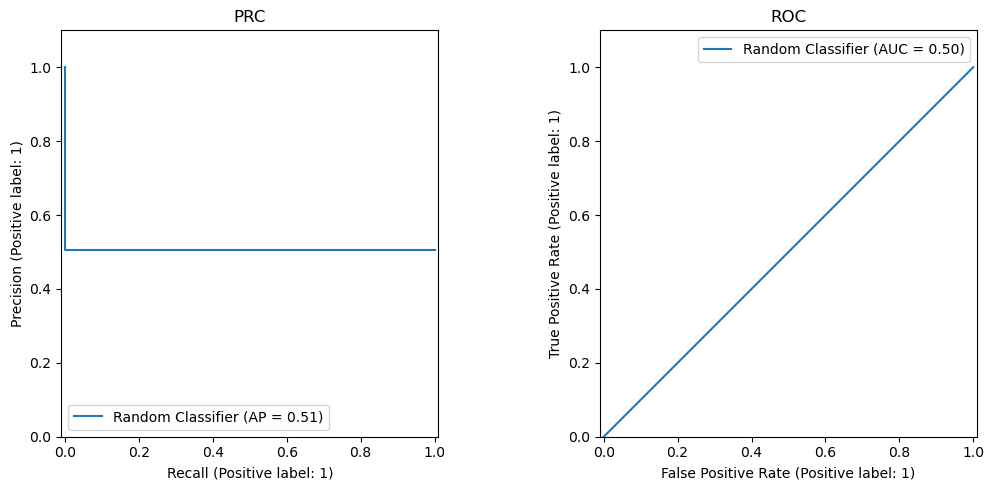

In [7]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()
    plt.show()  

depict_pr_roc(y_test, y_random, 'Random Classifier')

In [8]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


**Я решил подбирать с помощью кросс-валидации**

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [10]:
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
}

In [11]:
svc = SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2, scoring='average_precision') # 5 фолдов, average_precision - аналог pr-auc
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...........................................C=0.0001; total time=   6.5s
[CV] END ...........................................C=0.0001; total time=  10.2s
[CV] END ...........................................C=0.0001; total time=   6.2s
[CV] END ...........................................C=0.0001; total time=   5.0s
[CV] END ...........................................C=0.0001; total time=   4.9s
[CV] END ............................................C=0.001; total time=   4.8s
[CV] END ............................................C=0.001; total time=   5.0s
[CV] END ............................................C=0.001; total time=   5.2s
[CV] END ............................................C=0.001; total time=   4.9s
[CV] END ............................................C=0.001; total time=   5.1s
[CV] END .............................................C=0.01; total time=   4.2s
[CV] END ........................................

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [12]:
y_test_pred_svc = grid_search.predict_proba(X_test)[:,1]

SVC (C=1000) metrics
AUC-PR: 0.9837
AUC-ROC: 0.9865


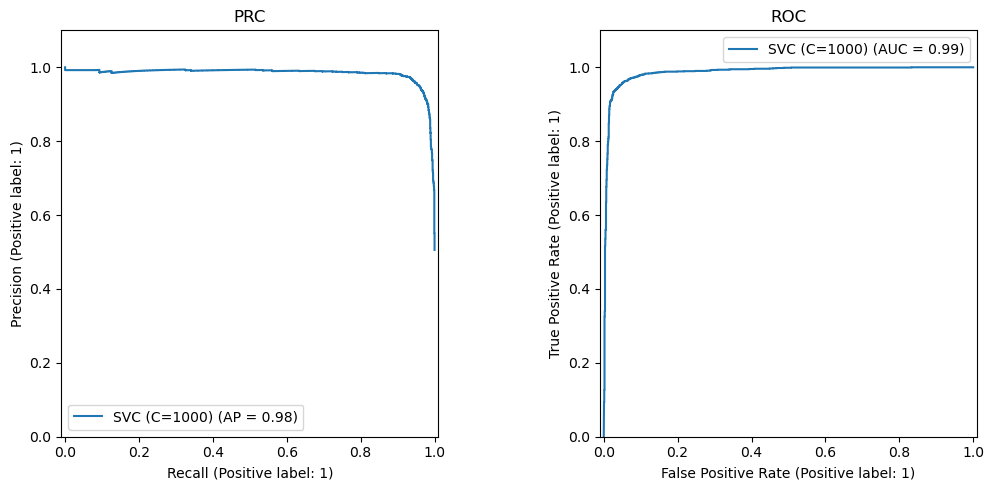

In [13]:
depict_pr_roc(y_test, y_test_pred_svc, 'SVC (C=1000)')

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_svc)
pr_auc = auc(recall_vals, precision_vals)

In [15]:
print(f'На тестовой выборке AUC-ROC = {round(roc_auc_score(y_test, y_test_pred_svc), 5)}')
print(f'На тестовой выборке AUC-PR = {round(pr_auc, 5)}')

На тестовой выборке AUC-ROC = 0.98652
На тестовой выборке AUC-PR = 0.98399


In [16]:
df_metrics.loc['SVC'] = [
      round(pr_auc, 5),
      round(roc_auc_score(y_test, y_test_pred_svc), 5),
      1000,
]

df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.50000,0.0
SVC,0.983990,0.98652,1000.0


Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

#### **При увеличении порога**:

**ROC кривая**: двигаясь справа налево, мы увеличиваем порог => более строго относим объекты к положительному классу => FPR падает, так как мы наращиваем свою увереннность в объектах, которые называем положительными.\
При этом мы упускаем много реально положительных объектов, которые имели веорятность ниже заданного нами высокого порога. 

**PR кривая**: при увеличении порога мы двигаемся справа налево. Recall монотонно уменьшается, так как FN растет (мы относим многие объекты с большой уверенностью модели в том, что они положительного класса, к отрицательному классу). Precision растет, но не монотонно.

#### **Монотонность:**
При уменьшении порога классификации, TPR и FPR могут только увеличиваться или оставаться неизменными => ROC кривая монотонно неубывающая.







В целом ROC-AUC демонстрирует качество разделения обоих классов, а PR-AUC качестов предсказания положительного класса


Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

Наша модель намного лучше случайного классификатора, так как у нее и roc-auc и auc-pr на тестовой выборке близки к 1

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
LogReg = LogisticRegression(penalty='l2')
grid_search_lr = GridSearchCV(LogReg, param_grid, cv=5, verbose=2, scoring='average_precision') # 5 фолдов, average_precision - аналог pr-auc
grid_search_lr.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ........................................

SVC (C=0.001) metrics
AUC-PR: 0.8338
AUC-ROC: 0.8453


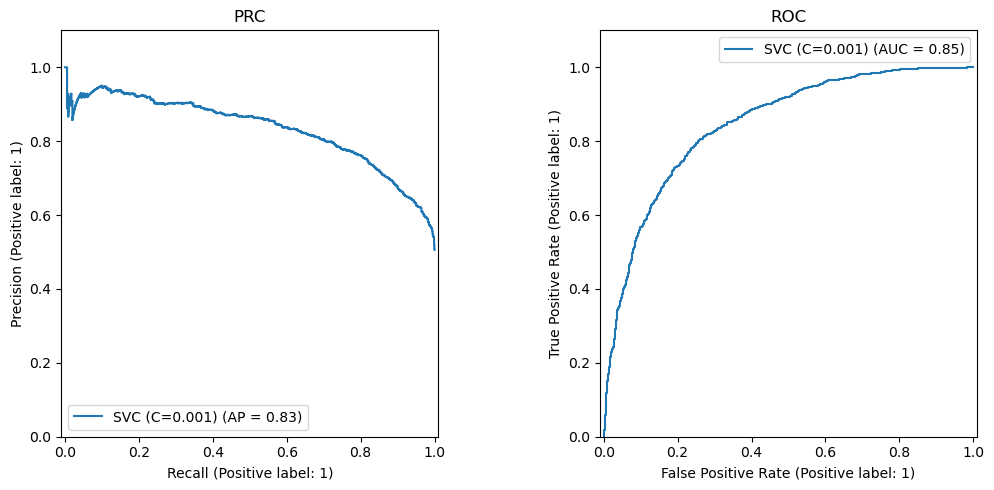

In [19]:
y_test_pred_logreg = grid_search_lr.predict_proba(X_test)[:,1]

depict_pr_roc(y_test, y_test_pred_logreg, 'SVC (C=0.001)')

In [20]:
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr = auc(recall_vals, precision_vals)


print(f'На тестовой выборке AUC-ROC = {round(roc_auc_score(y_test, y_test_pred_logreg), 5)}')
print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr, 5)}')

На тестовой выборке AUC-ROC = 0.84533
На тестовой выборке AUC-PR = 0.8336


In [21]:
df_metrics.loc['Logistic Regression'] = [
      round(pr_auc_lr, 5),
      round(roc_auc_score(y_test, y_test_pred_logreg), 5),
      0.001,
]



display(df_metrics.style
    .background_gradient(subset=['auc_pr', 'roc_auc_score'], cmap='RdYlGn'))

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVC,0.983990,0.986520,1000.000000
Logistic Regression,0.833600,0.845330,0.001000


На тестовых данных SVC заметно опережает Logreg => **в данных скорее всего есть сложные, нелинейные зависимости, которые лог регрессии сложнее распознать**

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

**В создании этого графика мне помог deepseek**

In [22]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [24]:

fig = go.Figure()

fpr1, tpr1, _ = roc_curve(y_test, y_random)
auc1 = auc(fpr1, tpr1)
fig.add_trace(go.Scatter(x=fpr1, y=tpr1, 
                         name=f'Random Classifier (AUC = {auc1:.3f})',
                         line=dict(color='#FF5252', width=3)))


fpr2, tpr2, _ = roc_curve(y_test, y_test_pred_svc)
auc2 = auc(fpr2, tpr2)
fig.add_trace(go.Scatter(x=fpr2, y=tpr2,
                         name=f'SVC (AUC = {auc2:.3f})',
                         line=dict(color='#2196F3', width=3, dash='dash')))


fpr3, tpr3, _ = roc_curve(y_test, y_test_pred_logreg)
auc3 = auc(fpr3, tpr3)
fig.add_trace(go.Scatter(x=fpr3, y=tpr3,
                         name=f'Logistic Regression (AUC = {auc3:.3f})',
                         line=dict(color='#6A0DAD', width=3)))

fig.update_layout(
    title='<b>ROC кривые разных классификаторов</b>',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=1200,
    height=800
)

fig.show()

c:\Users\User\anaconda3\Lib\site-packages\kaleido\__init__.py:14: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [352]:
# график можно посмотреть в ROC_curves_different_classifiers.png

In [25]:
fig = go.Figure()

pr1, rec1, _ = precision_recall_curve(y_test, y_random)
as1 = average_precision_score(y_test, y_random)
fig.add_trace(go.Scatter(x=rec1, y=pr1, 
                         name=f'Random Classifier (AUC-PR = {as1:.3f})',
                         line=dict(color='#FF5252', width=3)))


pr2, rec2, _ = precision_recall_curve(y_test, y_test_pred_svc)
as2 = average_precision_score(y_test, y_test_pred_svc)
fig.add_trace(go.Scatter(x=rec2, y=pr2,
                         name=f'SVC (AUC-PR = {as2:.3f})',
                         line=dict(color='#2196F3', width=3, dash='dash')))


pr3, rec3, _ = precision_recall_curve(y_test, y_test_pred_logreg)
as3 = average_precision_score(y_test, y_test_pred_logreg)
fig.add_trace(go.Scatter(x=rec3, y=pr3,
                         name=f'Logistic Regression (AUC-PR = {as3:.3f})',
                         line=dict(color='#6A0DAD', width=3)))

fig.update_layout(
    title='<b>PR кривые разных классификаторов</b>',
    xaxis_title='Recall',
    yaxis_title='Precision',
    width=1200,
    height=800
)

fig.show()

In [353]:
# график можно посмотреть в PR_curves_different_classifiers.png

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [26]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.50000,0.000
SVC,0.983990,0.98652,1000.000
Logistic Regression,0.833600,0.84533,0.001


In [27]:
round(0.983990 - 0.833600, 4), round(0.98652 - 0.84533, 4)

(0.1504, 0.1412)

In [28]:
y_train.sum()/len(y_train), y_test.sum()/len(y_test)

(0.49685714285714283, 0.5056666666666667)

**Ответ:** в общем разделении классов у SVM большое преимущество (AUC-ROC больше на 0.14).\
Разница в PR-AUC больше, значит преимущество SVM в отделении положительного класса больше.\
В целом здесь у SVC почти идеальное качество, у LR просто хорошее.\
Если выбирать из них, то почти во всех случаях для подобной задачи SVM лучше. LR лучше подходит только если важна интерпретируемость или ограничены вычислительные ресурсы (LR обучается быстрее).


#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [29]:
X, y = make_classification(
    n_samples=10000,          
    n_features=2,            
    n_informative=2,         #Оба признака информативные
    n_redundant=0,           
    random_state=42
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Решил не делить, так как все равно не нужна тестовая выборка

svm_model = SVC(kernel='linear', C=1000.0, random_state=42)
svm_model.fit(X, y)

# Получаем опорные векторы
support_vectors = svm_model.support_vectors_
support_vector_indices = svm_model.support_

print(f"Количество опорных векторов: {len(support_vectors)}")
print(f"Индексы опорных векторов: {support_vector_indices}")

Количество опорных векторов: 2917
Индексы опорных векторов: [   4   10   11 ... 9977 9983 9997]


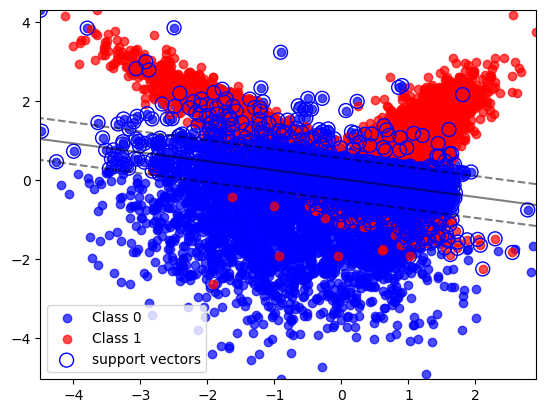

In [30]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создал сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовал выборку
    plt.scatter(
        X[y == 0, 0], X[y == 0, 1],  # Класс 0
        c='blue', label='Class 0', alpha=0.7
    )
    plt.scatter(
        X[y == 1, 0], X[y == 1, 1],  # Класс 1  
        c='red', label='Class 1', alpha=0.7
    )

    # Отрисовал опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],  # X координаты опорных векторов
            model.support_vectors_[:, 1],  # Y координаты опорных векторов
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()
    plt.show()
plot_svm_2D(X, y, svm_model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** опорными становятся объекты, лежащие на границе зазора или внутри.\
Это наиболее информативные объекты, которые находятся ближе всего к разделяющей границе и определяют положение разделяющей гиперплоскости.


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [31]:
logreg_model = LogisticRegression(penalty='l2', C=0.001, verbose=2, random_state=42)
logreg_model.fit(X, y)

LogisticRegression(C=0.001, random_state=42, verbose=2)

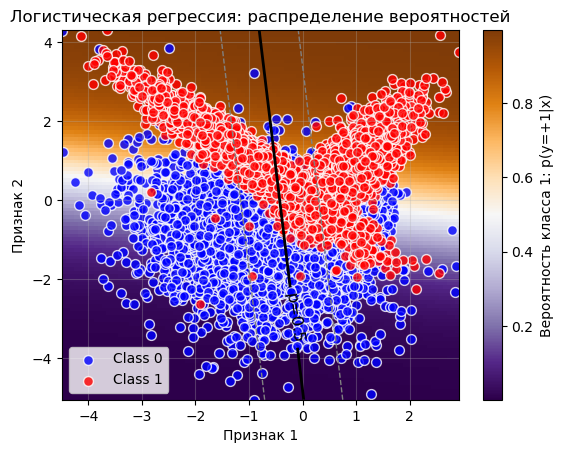

In [32]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    plt.scatter(
        X[y == 0, 0], X[y == 0, 1],  # Класс 0
        c='blue', label='Class 0', alpha=0.8, s=50, edgecolors='white'
    )
    plt.scatter(
        X[y == 1, 0], X[y == 1, 1],  # Класс 1
        c='red', label='Class 1', alpha=0.8, s=50, edgecolors='white'
    )

    # Добавляю линию уровня вероятности 0.5 (граница решения)
    contour = plt.contour(XX, YY, Z, levels=[0.5], colors='black', linewidths=2)
    plt.clabel(contour, inline=True, fontsize=12, fmt='p=0.5')

    # Добавляю дополнительные уровни вероятности для наглядности
    plt.contour(XX, YY, Z, levels=[0.25, 0.75], colors='gray', linewidths=1, linestyles='--')
    
    plt.colorbar(image, label='Вероятность класса 1: p(y=+1|x)')
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('Логистическая регрессия: распределение вероятностей')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

plot_logreg_2D(X, y, logreg_model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Область с вероятностью положительного класса = 0.5 визуализирована на картинке как белая линия.\
Сигмоида имеет наибольшую производную при P(1) = 0.5 => в этой области при небольшом изменении z вероятность принадлежности к положительному классу сильно меняется.\
Когда P(1) = 0.5, энтропия наибольшая => максимальная неопределеннось


#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [33]:
#def plot_calibration_curve(y_test, preds):
 #   bin_middle_points = []
  #  bin_real_ratios = []
   # n_bins = 10
    #for i in range(n_bins):
     #   l = 1.0 / n_bins * i
      #  r = 1.0 / n_bins * (i + 1)
       # bin_middle_points.append((l - r) / 2)
       # bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
    #plt.figure(figsize=(6,6))
    #plt.plot(bin_middle_points, bin_real_ratios)
    #plt.ylim([-0.05, 1.05])
    #plt.grid()

In [34]:
def plot_calibration_curve(y_test, preds, method='SVC', color1 = 'purple'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    y_test = np.array(y_test).flatten()
    preds = np.array(preds).flatten()
    
    for i in range(n_bins):
        l = i / n_bins
        r = (i + 1) / n_bins
        bin_middle_points.append((l + r) / 2)
        

        if i == n_bins - 1:
            mask = (preds >= l) & (preds <= r)
        else:
            mask = (preds >= l) & (preds < r)
        

        mask = np.array(mask).flatten()
        
        if mask.ndim > 1:
            mask = mask.flatten()
            
        n_in_bin = np.sum(mask)
        
        if n_in_bin > 0:
 
            y_in_bin = y_test[mask]
            ratio = np.mean(y_in_bin == 1)
            bin_real_ratios.append(ratio)
        else:
            bin_real_ratios.append(0.0)

    plt.figure(figsize=(12,8))
    plt.plot(bin_middle_points, bin_real_ratios, color=color1)
    plt.plot([0, 1], [0, 1], '--', color='gray') # идеальная калибровка
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('Предсказанная вероятность принадлежности к положительному классу',fontsize =12)
    plt.ylabel('Реальная вероятность принадлежности к положительному классу', fontsize =12)
    plt.title(f'Калибровочная кривая для {method}', fontsize =14, pad=15)
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [35]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
svc = SVC(probability=True)
grid_search = GridSearchCV(svc, param_grid, cv=5, verbose=2, scoring='average_precision') # 5 фолдов, average_precision - аналог pr-auc
grid_search.fit(X_train, y_train)
grid_search.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...........................................C=0.0001; total time=   5.3s
[CV] END ...........................................C=0.0001; total time=   5.3s
[CV] END ...........................................C=0.0001; total time=   5.0s
[CV] END ...........................................C=0.0001; total time=   5.1s
[CV] END ...........................................C=0.0001; total time=   5.0s
[CV] END ............................................C=0.001; total time=   4.8s
[CV] END ............................................C=0.001; total time=   4.7s
[CV] END ............................................C=0.001; total time=   5.0s
[CV] END ............................................C=0.001; total time=   4.9s
[CV] END ............................................C=0.001; total time=   5.1s
[CV] END .............................................C=0.01; total time=   3.6s
[CV] END ........................................

array([1, 0, 0, ..., 0, 1, 1])

In [37]:
svc_pred_probs_test = grid_search.predict_proba(X_test)[:,1] # получаю вероятности

In [38]:
LogReg = LogisticRegression(penalty='l2')
grid_search_lr = GridSearchCV(LogReg, param_grid, cv=5, verbose=2, scoring='average_precision') # 5 фолдов, average_precision - аналог pr-auc
grid_search_lr.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ........................................

In [39]:
y_test_pred_logreg_probs = grid_search_lr.predict_proba(X_test)[:,1] # получаю вероятности положительного класса
y_test_pred_logreg_probs

array([0.6546565 , 0.02717398, 0.21400636, ..., 0.08379429, 0.81214756,
       0.90036665])

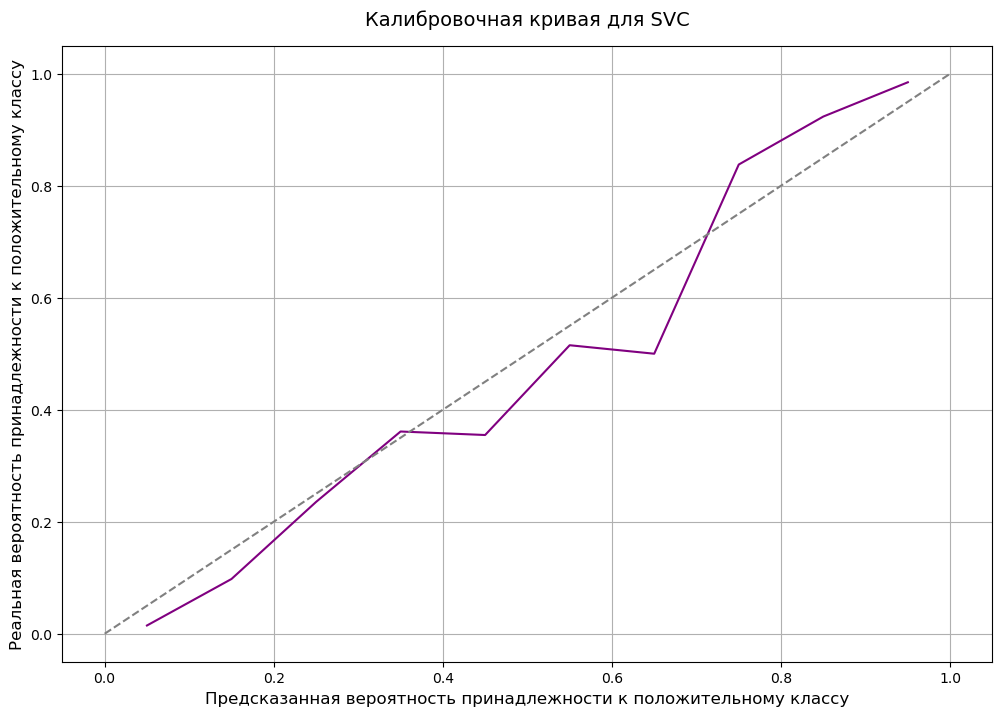

In [40]:

plot_calibration_curve(y_test, svc_pred_probs_test, method='SVC', color1 = 'purple')


#plot_calibration_curve(y_test, y_test_pred_logreg_probs)

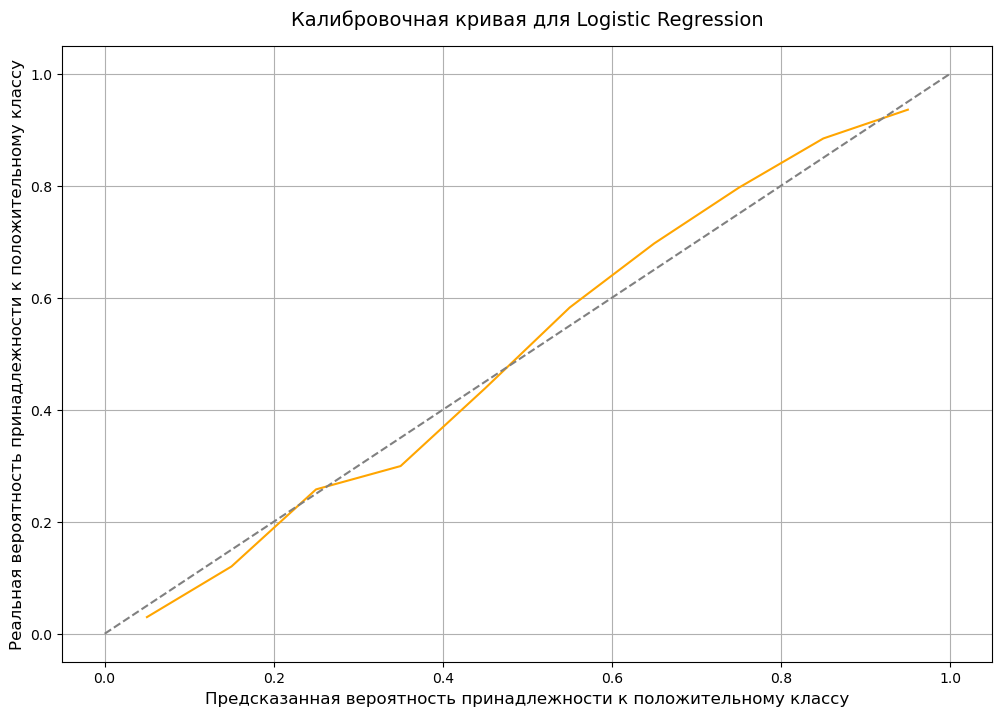

In [41]:
plot_calibration_curve(y_test, y_test_pred_logreg_probs, method='Logistic Regression', color1 = 'orange')

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** кривая для Логрега откалибрована лучше, чем кривая для SVM, так как она в среднем менее удалена от кривой идеально откалиброванной модели (диагональ).\
Это ожидаемо, так как Логрег концентрируется на получении верных вероятностей, а SVM - на верном прогнозе класса

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [42]:
from sklearn.metrics import log_loss

logloss_svc = log_loss(y_test, svc_pred_probs_test)
logloss_logreg = log_loss(y_test, y_test_pred_logreg_probs)

round(logloss_svc, 4), round(logloss_logreg, 4)

(0.1627, 0.4905)

Согласно LogLoss SVC лучше откалибрована, несмотря на кажущееся преимущество логрега по визуализациям кривых.\
Это нессответствие происходит потому, что LogLoss оцениает индивидуально калибровку каждого объекта, а кривая по батчам.    

In [43]:
from sklearn.metrics import brier_score_loss

brier_svc = brier_score_loss(y_test, svc_pred_probs_test)
brier_lr = brier_score_loss(y_test, y_test_pred_logreg_probs)

round(brier_svc, 4), round(brier_lr, 4)

(0.0362, 0.161)

In [44]:
df_metrics_calibr = pd.DataFrame(
    columns=['Logloss', 'Brier Score', 'Количество фолдов', 'Метод калибровки']
)

df_metrics_calibr.loc['SVC '] = [
      round(logloss_svc, 4),
      round(brier_svc, 4),
      5,
      ' '
]

df_metrics_calibr.loc['Log Reg '] = [
      round(logloss_logreg, 4),
      round(brier_lr, 4),
      5,
      ' '
]

df_metrics_calibr

,Logloss,Brier Score,Количество фолдов,Метод калибровки
SVC,0.1627,0.0362,5,
Log Reg,0.4905,0.1610,5,


Исходя из Brier Score у SVC отличная калибровка, а Логрег требует дополнительной калибровки

Изучите распределение ответов классификаторов при помощи гистограмм

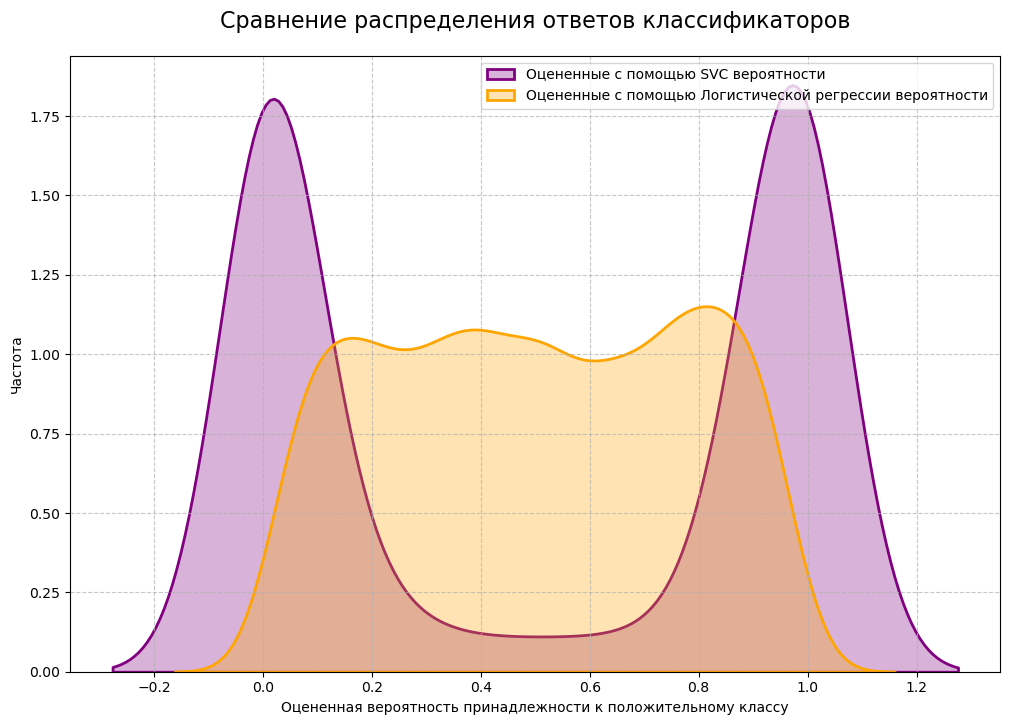

In [45]:
import seaborn as sns
plt.figure(figsize=(12, 8), dpi=100)
sns.kdeplot(
    data=svc_pred_probs_test,
    color="purple",
    label="Оцененные с помощью SVC вероятности",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

sns.kdeplot(
    data=y_test_pred_logreg_probs,
    color="orange",
    label="Оцененные с помощью Логистической регрессии вероятности",
    linewidth=2,
    fill=True,
    alpha=0.3,
)

plt.title("Сравнение распределения ответов классификаторов",fontsize=16, pad=20)
plt.xlabel("Оцененная вероятность принадлежности к положительному классу")
plt.ylabel("Частота")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** у ответов SVC бимодальное распределение, оно более уверенное. У ответов Логрега распределение похоже на равномерное, оно более осторожное с точки зрения оценивания неопределенности.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

In [46]:
from sklearn.calibration import CalibratedClassifierCV

In [47]:
# я решил применить трехчастную кросс-валидацию
calibrated_svc = CalibratedClassifierCV(
    estimator=SVC(probability=False, random_state=42),
    method='sigmoid',
    cv=3  
)

calibrated_svc.fit(X_train, y_train) # обучаю на трейне

calibrated_probs = calibrated_svc.predict_proba(X_test) # предсказываю на тесте

In [48]:
calibrated_probs[:,1][:10]

array([0.99698364, 0.01658922, 0.01542583, 0.0190235 , 0.32277207,
       0.96357605, 0.99530362, 0.98575726, 0.01133717, 0.99625006])

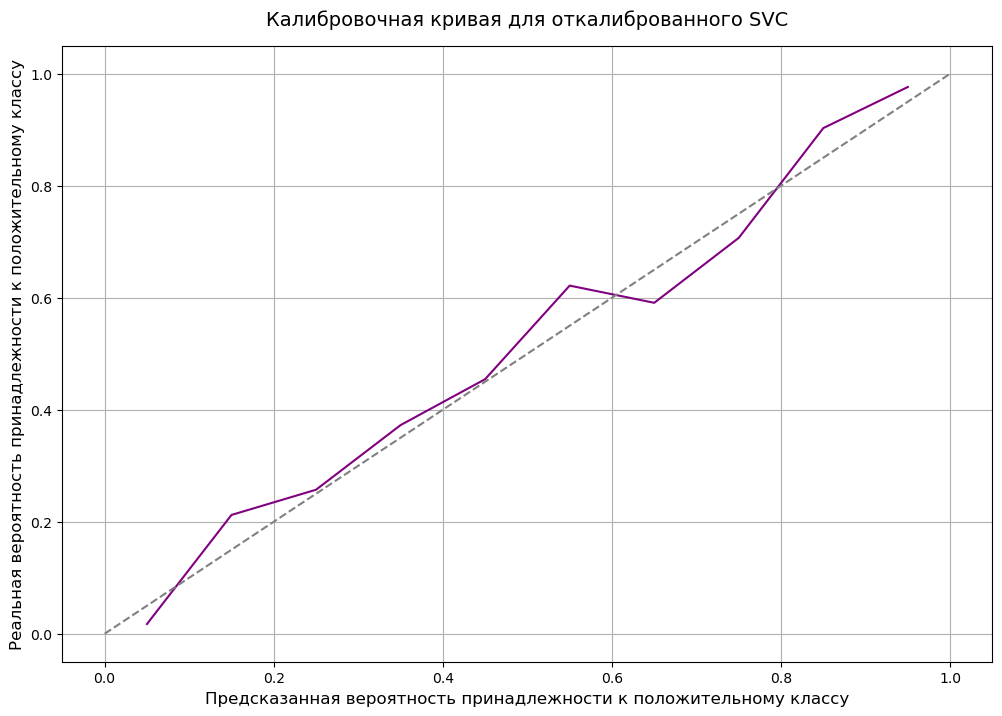

In [49]:
plot_calibration_curve(y_test, calibrated_probs[:,1], method='откалиброванного SVC', color1 = 'purple')


**Ответ:** **Калибровочная кривая улучшилась!**

**Посмотрим на качество калибровки:**

In [50]:
logloss_svc_calibrated = log_loss(y_test, calibrated_probs[:,1])

brier_svc_calibrated = brier_score_loss(y_test, calibrated_probs[:,1])

round(logloss_svc_calibrated, 4), round(brier_svc_calibrated, 4)

(0.1698, 0.0473)

In [51]:
df_metrics_calibr.loc['SVC с калибровкой'] = [
      round(logloss_svc_calibrated, 4),
      round(brier_svc_calibrated, 4),
      3,
      'sigmoid'
]

df_metrics_calibr

,Logloss,Brier Score,Количество фолдов,Метод калибровки
SVC,0.1627,0.0362,5,
Log Reg,0.4905,0.1610,5,
SVC с калибровкой,0.1698,0.0473,3,sigmoid


По Brier score и logloss нет улучшшения. Попробую подобрать **оптимальное количество фолдов и вид калибровки**:

In [52]:
#methods = ['sigmoid', 'isotonic']
#cvs = [3, 5]

param_grid_calibrated_svc = {
    'method': ['sigmoid', 'isotonic'],
    'cv': [3, 5]
}


calibrated_svc = CalibratedClassifierCV(
    estimator=SVC(probability=False, random_state=42),
  #  method='sigmoid',
 #   cv=3  
)

grid_search_calibrated_svc = GridSearchCV(calibrated_svc, param_grid_calibrated_svc, verbose=2, scoring='average_precision') 
grid_search_calibrated_svc.fit(X_train, y_train)

#calibrated_svc.fit(X_train, y_train) # обучаю на трейне

calibrated_probs_upd = grid_search_calibrated_svc.predict_proba(X_test) # предсказываю на тесте

logloss_svc_calibrated_upd = log_loss(y_test, calibrated_probs_upd[:,1])

brier_svc_calibrated_upd = brier_score_loss(y_test, calibrated_probs_upd[:,1])

round(logloss_svc_calibrated_upd, 4), round(brier_svc_calibrated_upd, 4)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...............................cv=3, method=sigmoid; total time=   0.7s
[CV] END ...............................cv=3, method=sigmoid; total time=   0.7s
[CV] END ...............................cv=3, method=sigmoid; total time=   0.7s
[CV] END ...............................cv=3, method=sigmoid; total time=   0.7s
[CV] END ...............................cv=3, method=sigmoid; total time=   0.7s
[CV] END ..............................cv=3, method=isotonic; total time=   0.6s
[CV] END ..............................cv=3, method=isotonic; total time=   0.6s
[CV] END ..............................cv=3, method=isotonic; total time=   0.8s
[CV] END ..............................cv=3, method=isotonic; total time=   0.9s
[CV] END ..............................cv=3, method=isotonic; total time=   0.9s
[CV] END ...............................cv=5, method=sigmoid; total time=   1.4s
[CV] END ...............................cv=5, met

(0.1676, 0.0466)

In [53]:
print(f'Лучшими параметрами оказались: количество фолдов при кросс-валидации (cv) = {grid_search_calibrated_svc.best_params_['cv']}, метод калибровки: {grid_search_calibrated_svc.best_params_['method']}')

Лучшими параметрами оказались: количество фолдов при кросс-валидации (cv) = 5, метод калибровки: sigmoid


In [54]:
df_metrics_calibr.loc['SVC с калибровкой с аодобранными cv и method'] = [
      round(logloss_svc_calibrated_upd, 4),
      round(brier_svc_calibrated_upd, 4),
      f'{grid_search_calibrated_svc.best_params_['cv']}',
      f' {grid_search_calibrated_svc.best_params_['method']}'
]

display(df_metrics_calibr.style
    .background_gradient(subset=['Logloss', 'Brier Score'], cmap='RdYlGn_r'))

,Logloss,Brier Score,Количество фолдов,Метод калибровки
SVC,0.162700,0.036200,5,
Log Reg,0.490500,0.161000,5,
SVC с калибровкой,0.169800,0.047300,3,sigmoid
SVC с калибровкой с аодобранными cv и method,0.167600,0.046600,5,sigmoid


Не получилось добиться лучшего качества калибровки, чем в исходном SVC

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [55]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [56]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [57]:
# Прочитаем датасет
df = pd.read_csv(path)
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [58]:
df.shape[0], df.ID.nunique()

(1000, 1000)

In [59]:
# Заменим пропуски категориальных переменных
df.isnull().sum()

ID                   0
Marital Status       7
Gender              11
Income               6
Children             8
Education            0
Occupation           0
Home Owner           4
Cars                 9
Commute Distance     0
Region               0
Age                  8
Purchased Bike       0
dtype: int64

In [60]:
df[['Marital Status','Gender', 'Home Owner']] = df[['Marital Status','Gender', 'Home Owner']].fillna('undefined')

In [61]:
# Отделим X и y
X = df.drop(['ID', 'Purchased Bike'], axis=1)
y = df['Purchased Bike']

In [62]:
# Разделим на категориальные признаки и числовые
X_numerical = X[['Income', 'Children', 'Cars', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [63]:

y = np.where(y=='Yes', 1, 0) # для удобства сразу преобразовываю таргет в численный тип

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [65]:
from sklearn.preprocessing import OrdinalEncoder

In [66]:
import time
start = time.time()

ord_encoder = OrdinalEncoder()
X_train1 = ord_encoder.fit_transform(X_train)
X_test1 = ord_encoder.fit_transform(X_test)

logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
logreg_model.fit(X_train1, y_train)

y_test_pred_logreg = logreg_model.predict_proba(X_test1)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr = auc(recall_vals, precision_vals)

time1 = time.time() - start
print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr, 5)}')

print(f'{time1} секунд')

На тестовой выборке AUC-PR = 0.5793
0.013999462127685547 секунд


In [67]:
# dataframe для сравнения
# моделей по метрикам
df_models = pd.DataFrame(
    columns=['auc_pr', 'time']   #, 'roc_auc_score', 'reg_const'
)
# добавление очередной строки с характеристиками метода
df_models.loc['LogReg (Ordinal Encoding)'] = [
      round(pr_auc_lr, 5),
      round(time1, 5)
    #  roc_auc_score(y_test, y_random),
     # 0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_models

,auc_pr,time
LogReg (Ordinal Encoding),0.5793,0.014


Без подбора гиперпараметров и использования всех признаков качество не очень хорошее. Чуть лучше случайного классификатора

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [68]:
start = time.time()

X_train2 = pd.get_dummies(X_train, drop_first=True)
X_test2 = pd.get_dummies(X_test, drop_first=True)

logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
logreg_model.fit(X_train2, y_train)

y_test_pred_logreg = logreg_model.predict_proba(X_test2)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr2 = auc(recall_vals, precision_vals)

#print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr2, 5)}')

time2 = round(time.time() - start, 5)
print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr, 5)}')
print(f'{round(time2, 5)} секунд')

На тестовой выборке AUC-PR = 0.5793
0.03 секунд


In [69]:
df_models.loc['LogReg (OHE)'] = [
      round(pr_auc_lr2, 5),
      time2
    #  roc_auc_score(y_test, y_random),
     # 0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_models

,auc_pr,time
LogReg (Ordinal Encoding),0.57930,0.014
LogReg (OHE),0.66073,0.030


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [70]:
# здесь для удобства добавляю таргет как столбец
Xtc = X_train.copy()
Xtc['buy'] = y_train
Xtc.head()

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe,1
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America,0
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe,1
902,Single,Male,Bachelors,Skilled Manual,Yes,2-5 Miles,North America,0
15,Single,Female,High School,Manual,Yes,0-1 Miles,Europe,1


Я написал 2 реализации функции, выполняющей Mean-target Encoding. **Первая работает за O(n^2)**, при большом датасете это долго.\
**Вторая работает за O(n)**    

##### **Первая реализация**

In [71]:
def mean_target_encoding(cat_features_df, target): # на вход подается датасет с категориальными фичами и таргет
    for col in cat_features_df.loc[:, cat_features_df.columns != target].columns:
        for category in cat_features_df[col].unique():
            cat_features_df.loc[cat_features_df[col] == category, col] = cat_features_df[cat_features_df[col] == category][target].mean()

    return cat_features_df      



In [72]:
mean_target_encoding(Xtc, 'buy')

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372,1
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079,0
110,0.552632,0.504155,0.437186,0.482759,0.48927,0.535581,0.488372,1
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079,0
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372,1
...,...,...,...,...,...,...,...,...
483,0.415423,0.463158,0.543307,0.484848,0.478599,0.535581,0.488372,0
375,0.415423,0.504155,0.529915,0.478947,0.478599,0.535581,0.488372,0
968,0.552632,0.463158,0.333333,0.484848,0.48927,0.437086,0.430079,0
756,0.415423,0.463158,0.529915,0.478947,0.48927,0.535581,0.430079,1


In [73]:
Xtc.head(3)

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372,1
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079,0
110,0.552632,0.504155,0.437186,0.482759,0.48927,0.535581,0.488372,1


#### **Вторая реализация (быстрее)**

In [74]:
Xtc2 = X_train.copy()
Xtc2['buy'] = y_train
Xtc2.head(3)

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,Married,Female,Bachelors,Clerical,Yes,0-1 Miles,Europe,1
540,Single,Female,Graduate Degree,Management,Yes,1-2 Miles,North America,0
110,Single,Female,Partial College,Manual,No,0-1 Miles,Europe,1


In [75]:
def mean_target_encoding2(cat_features_df, target): # на вход подается датасет с категориальными фичами и таргет
    for col in cat_features_df.loc[:, cat_features_df.columns != target].columns:
        cat_features_df[col] = cat_features_df.groupby(col)[target].transform('mean')

    return cat_features_df      

In [76]:
mean_target_encoding2(Xtc2, 'buy')

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372,1
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079,0
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372,1
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079,0
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372,1
...,...,...,...,...,...,...,...,...
483,0.415423,0.463158,0.543307,0.484848,0.478599,0.535581,0.488372,0
375,0.415423,0.504155,0.529915,0.478947,0.478599,0.535581,0.488372,0
968,0.552632,0.463158,0.333333,0.484848,0.489270,0.437086,0.430079,0
756,0.415423,0.463158,0.529915,0.478947,0.489270,0.535581,0.430079,1


In [77]:
Xtc2.head(3)

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,buy
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372,1
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079,0
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372,1


In [78]:
# фкнкция для применения маппинга на тестовую выборку

def apply_encoding_to_test(X_test, X_train_encoded, target_col):
    X_test_encoded = X_test.copy()
    for col in X_test.columns:
        # Беру маппинг из тренировочных данных
        mapping = X_train_encoded.groupby(col)[target_col].mean()
        X_test_encoded[col] = X_test[col].map(mapping)
    return X_test_encoded

##### **Кодирование + обучение + тест**

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

Xtrc = X_train.copy()
Xtrc['buy'] = y_train

Xtec = X_test.copy()



start = time.time()


Xtrc_encoded = mean_target_encoding2(Xtrc, 'buy')

Xtec_encoded = apply_encoding_to_test(Xtec, Xtrc_encoded, 'buy')  # применяю к тестовой выборке
Xtec_encoded = Xtec_encoded.fillna(Xtrc_encoded['buy'].mean())

Xtrc_final = Xtrc_encoded.drop('buy', axis=1) # удаляю таргет из трейн выборки перед обучением



logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
logreg_model.fit(Xtrc_final, y_train)

y_test_pred_logreg = logreg_model.predict_proba(Xtec_encoded)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr3 = auc(recall_vals, precision_vals)

time3 = round(time.time() - start, 5)
print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr3, 5)}')

print(f'{time3} секунд')

На тестовой выборке AUC-PR = 0.74
0.05005 секунд


In [80]:
df_models.loc['LogReg (Mean-target-encoding)'] = [
      round(pr_auc_lr3, 5),
      time3
 
]

df_models

display(df_models.style
    .background_gradient(subset=['auc_pr'], cmap='RdYlGn'))

,auc_pr,time
LogReg (Ordinal Encoding),0.579300,0.014000
LogReg (OHE),0.660730,0.030000
LogReg (Mean-target-encoding),0.740000,0.050050


**Mean-target-encoding оказался самым эффективным способом**, при этом он работает в ~5 раз дольше, что для больших данных может быть критично

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [81]:
# your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

Для начала я хочу посмотреть на разницу AUC-ROC на трейн и тест выборке прошлой модели, чтоб понять, **насколько сильное переобучение сейчас**

In [82]:
Xtrc_encoded_fs = Xtrc_encoded.drop(columns=['buy'])

In [83]:
print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr3, 5)}')

y_train_pred_logreg = logreg_model.predict_proba(Xtrc_encoded_fs)[:,1]    # предсказываю для трейна

precision_vals, recall_vals, thresholds = precision_recall_curve(y_train, y_train_pred_logreg)
pr_auc_lr3_train = auc(recall_vals, precision_vals)

print(f'На обучающей выборке AUC-PR = {round(pr_auc_lr3_train, 5)}')

print(f'Абсолютная разница AUC-PR = {round(pr_auc_lr3_train, 5) - round(pr_auc_lr3, 5)}')


На тестовой выборке AUC-PR = 0.74
На обучающей выборке AUC-PR = 0.63189
Абсолютная разница AUC-PR = -0.10811000000000004


Нетипичная картина, на тестовой выборке качество лучше

**Я добавляю шум из нормального распределения  с разными дисперсиями**

#### Функция MTE с шумом

In [84]:
def mean_target_encoding_with_noise(cat_features_df, target, noise_level=0.05, random_state=777):
    
    np.random.seed(random_state)
    df_encoded = cat_features_df.copy()
    
    for col in cat_features_df.loc[:, cat_features_df.columns != target].columns:
        means = cat_features_df.groupby(col)[target].mean()
        
        # Применяю кодировку
        df_encoded[col] = cat_features_df[col].map(means)
        
        # Добавляю шум к обучающим данным
        # Шум из нормального распределения с std = noise_level * std таргета
        target_std = cat_features_df[target].std()
        noise = np.random.normal(0, noise_level * target_std, size=len(df_encoded))
        df_encoded[col] += noise
    
    return df_encoded

#### Обучаю модель

Пробую разные уровни шума

In [85]:
for noise_level in tqdm([0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3]):

    X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

    Xtrc = X_train.copy()
    Xtrc['buy'] = y_train
    Xtec = X_test.copy()

    start = time.time()


    Xtrc_encoded = mean_target_encoding_with_noise(Xtrc, 'buy', noise_level=noise_level, random_state=777)

    # К тестовой выборке применяю обычную кодировку без шума
    Xtec_encoded = apply_encoding_to_test(Xtec, Xtrc_encoded, 'buy')
    Xtec_encoded = Xtec_encoded.fillna(Xtrc_encoded['buy'].mean())

    Xtrc_final = Xtrc_encoded.drop('buy', axis=1)

    logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
    logreg_model.fit(Xtrc_final, y_train)

    y_test_pred_logreg = logreg_model.predict_proba(Xtec_encoded)[:,1]

    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
    pr_auc_lr4 = auc(recall_vals, precision_vals)

    time4 = round(time.time() - start, 5)
    print(f'Уровень шума = {noise_level}')
    print(f'На тестовой выборке AUC-PR = {round(pr_auc_lr4, 5)}')
    print(f'{time4} секунд')

 38%|███▊      | 3/8 [00:00<00:00, 20.41it/s]

Уровень шума = 0.01
На тестовой выборке AUC-PR = 0.49217
0.036 секунд
Уровень шума = 0.03
На тестовой выборке AUC-PR = 0.73775
0.048 секунд
Уровень шума = 0.05
На тестовой выборке AUC-PR = 0.74
0.05 секунд
Уровень шума = 0.08
На тестовой выборке AUC-PR = 0.73775
0.035 секунд
Уровень шума = 0.1
На тестовой выборке AUC-PR = 0.73775
0.042 секунд


100%|██████████| 8/8 [00:00<00:00, 22.86it/s]


Уровень шума = 0.15
На тестовой выборке AUC-PR = 0.74
0.053 секунд
Уровень шума = 0.2
На тестовой выборке AUC-PR = 0.73775
0.025 секунд
Уровень шума = 0.3
На тестовой выборке AUC-PR = 0.74
0.024 секунд


Поднять ROC - AUC больше 0.74 не вышло, но мы сохранили результат, **это уже хорошо** 

Выберем из моделей, дающих roc-auc = 0.74 модель с **наименьшей разницей между трейн и тест выборкой**

In [86]:
for noise_level in tqdm([0.05, 0.15, 0.3]):
    X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

    Xtrc = X_train.copy()
    Xtrc['buy'] = y_train
    Xtec = X_test.copy()

    start = time.time()


    Xtrc_encoded = mean_target_encoding_with_noise(Xtrc, 'buy', noise_level=noise_level, random_state=777)

    # К тестовой выборке применяю обычную кодировку без шума
    Xtec_encoded = apply_encoding_to_test(Xtec, Xtrc_encoded, 'buy')
    Xtec_encoded = Xtec_encoded.fillna(Xtrc_encoded['buy'].mean())

    Xtrc_final = Xtrc_encoded.drop('buy', axis=1)

    logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
    logreg_model.fit(Xtrc_final, y_train)

    y_test_pred_logreg = logreg_model.predict_proba(Xtec_encoded)[:,1]

    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
    pr_auc_lr4 = auc(recall_vals, precision_vals)

    
    y_train_pred_logreg = logreg_model.predict_proba(Xtrc_final)[:,1]

    precision_vals_tr, recall_vals_tr, thresholds_tr = precision_recall_curve(y_train, y_train_pred_logreg)
    pr_auc_lr4_train = auc(recall_vals_tr, precision_vals_tr)

    time4 = round(time.time() - start, 5)
    print(f'Уровень шума = {noise_level}')
    print(f'Разгица ROC-AUC между трейн и тест выборкой = {round(pr_auc_lr4_train - pr_auc_lr4, 5)}')
    print(f'{time4} секунд')

100%|██████████| 3/3 [00:00<00:00, 38.96it/s]

Уровень шума = 0.05
Разгица ROC-AUC между трейн и тест выборкой = -0.10745
0.02499 секунд
Уровень шума = 0.15
Разгица ROC-AUC между трейн и тест выборкой = -0.11712
0.02609 секунд
Уровень шума = 0.3
Разгица ROC-AUC между трейн и тест выборкой = -0.13545
0.01492 секунд


In [87]:
X_train.shape

(750, 7)

Наименьшая разница при уровне шума = **0.05**

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума не помогло. Я связываю это с достаточно большим кол-вом данных, плюс, видимо, переобучения не было изначально

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [88]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [89]:
# your code here

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



### EDA числовых признаков

In [90]:
X_numerical.head()

,Income,Children,Cars,Age
0,40000.0,1.0,0.0,42.0
1,30000.0,3.0,1.0,43.0
2,80000.0,5.0,2.0,60.0
3,70000.0,0.0,1.0,41.0
4,30000.0,0.0,0.0,36.0


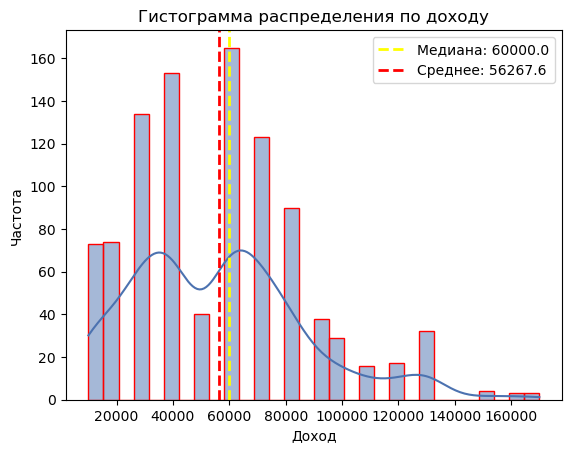

In [91]:
sns.histplot(X_numerical['Income'], bins=30, kde=True, color='#4C72B0', edgecolor='red')

plt.axvline(X_numerical['Income'].median(), color='yellow', linestyle='--', linewidth=2, label=f'Медиана: {X_numerical['Income'].median():.1f}')
plt.axvline(X_numerical['Income'].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее: {X_numerical['Income'].mean():.1f}')

plt.xlabel('Доход')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по доходу')
plt.legend()
plt.show()

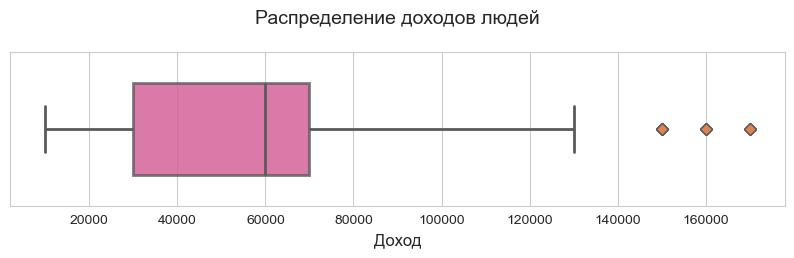

In [92]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 2))
boxplot = sns.boxplot(
    data=X_numerical['Income'], 
    orient="h",
    width=0.6,
    color="#E84393",
    linewidth=2,
    flierprops=dict(
        markerfacecolor='#DD8452',
        marker='D', 
        markersize=6
    ),
    boxprops=dict(alpha=0.8)
)
plt.title("Распределение доходов людей", pad=20, fontsize=14)
plt.xlabel("Доход", fontsize=12)
#plt.yticks([])
plt.show()

In [93]:
X_numerical[X_numerical['Income'] > 140000].shape[0]

10

In [94]:
# Выбросов немного, оставлю их.

In [95]:
X_numerical['Income'].unique()

array([ 40000.,  30000.,  80000.,  70000.,  10000., 160000.,  20000.,
           nan,  90000., 170000.,  60000., 100000., 130000., 120000.,
       150000.,  50000., 110000.])

Выбросов не очень много. Я предполагаю, что распределение логнормальное. Проверим это:

C:\Users\User\AppData\Local\Temp\ipykernel_1920\814580583.py:5: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



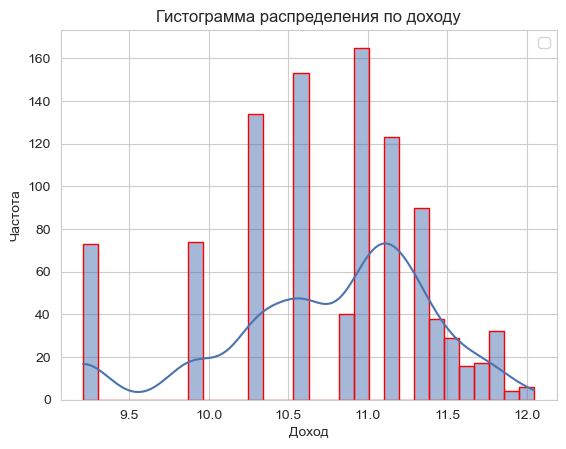

In [96]:
sns.histplot(np.log1p(X_numerical['Income']), bins=30, kde=True, color='#4C72B0', edgecolor='red')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по доходу')
plt.legend()
plt.show()

Не уверен, что логнормальное

In [97]:
X_numerical.isnull().sum()

Income      6
Children    8
Cars        9
Age         8
dtype: int64

In [98]:
#Заполняю пропуски в доходе медианой, их немного

X_numerical['Income'].fillna(X_numerical['Income'].median(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1920\1441679841.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\User\AppData\Local\Temp\ipykernel_1920\1441679841.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



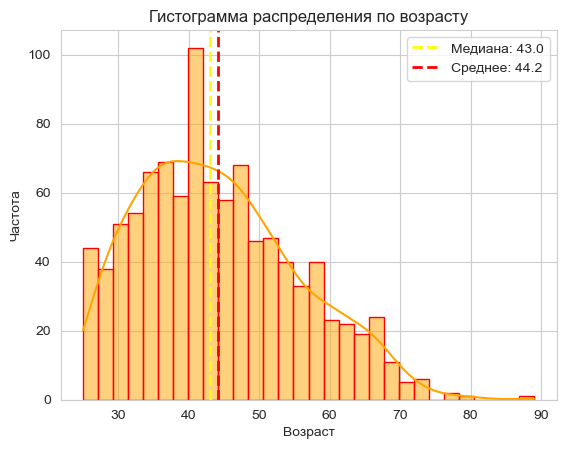

In [99]:
sns.histplot(X_numerical['Age'], bins=30, kde=True, color='orange', edgecolor='red')

plt.axvline(X_numerical['Age'].median(), color='yellow', linestyle='--', linewidth=2, label=f'Медиана: {X_numerical['Age'].median():.1f}')
plt.axvline(X_numerical['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Среднее: {X_numerical['Age'].mean():.1f}')

plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Гистограмма распределения по возрасту')
plt.legend()
plt.show()

Судя по гистограмме, есть выбросы

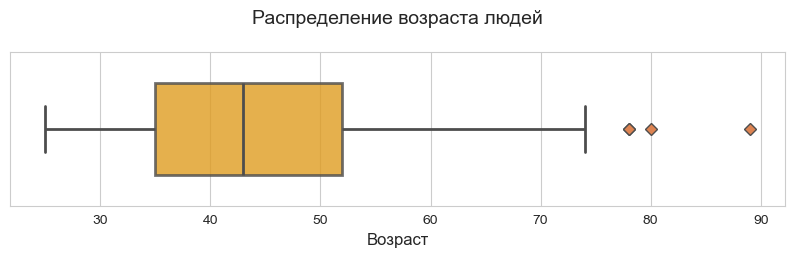

In [100]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 2))
boxplot = sns.boxplot(
    data=X_numerical['Age'], 
    orient="h",
    width=0.6,
    color="orange",
    linewidth=2,
    flierprops=dict(
        markerfacecolor='#DD8452',
        marker='D', 
        markersize=6
    ),
    boxprops=dict(alpha=0.8)
)
plt.title("Распределение возраста людей", pad=20, fontsize=14)
plt.xlabel("Возраст", fontsize=12)
#plt.yticks([])
plt.show()

In [101]:
X_numerical[X_numerical['Age'] > 75].shape[0]

4

Выбросов по возрасту почти нет. Оставляем как есть.

In [102]:
# пропуски заменяю медианой

X_numerical['Age'].fillna(X_numerical['Age'].median(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1920\4200533920.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\User\AppData\Local\Temp\ipykernel_1920\4200533920.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



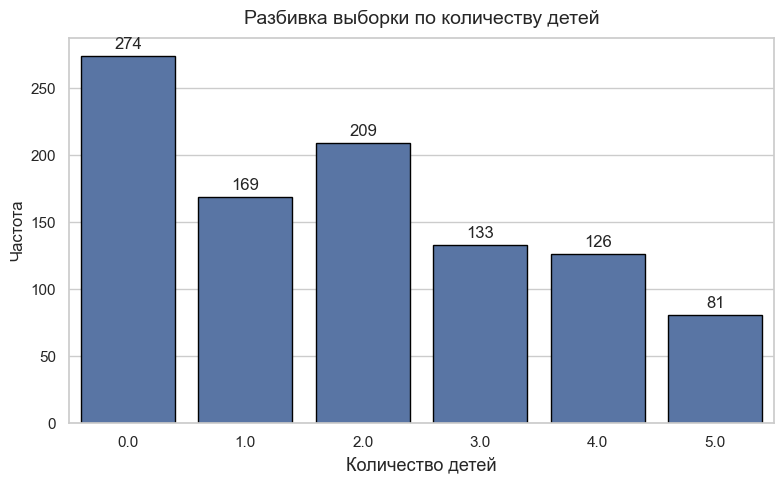

In [103]:
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

ax = sns.countplot(
    data=X_numerical,
    x='Children',

    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Разбивка выборки по количеству детей', fontsize=14, pad=10)
plt.xlabel('Количество детей', fontsize=13)
plt.ylabel('Частота', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [104]:
X_numerical['Children'].median()

2.0

In [105]:
#Заменим пропуски медианой - 2 ребенка, как ине кажется, это достаточно правдоподобно

X_numerical['Children'].fillna(X_numerical['Children'].median(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1920\3196344663.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\User\AppData\Local\Temp\ipykernel_1920\3196344663.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



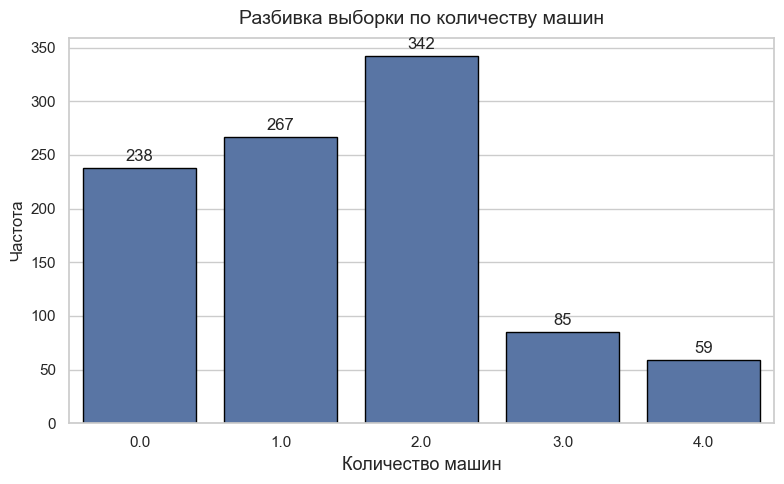

In [106]:
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

ax = sns.countplot(
    data=X_numerical,
    x='Cars',
    edgecolor='black'
)

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.title('Разбивка выборки по количеству машин', fontsize=14, pad=10)
plt.xlabel('Количество машин', fontsize=13)
plt.ylabel('Частота', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [107]:
X_numerical['Cars'].median()

1.0

In [108]:
# Заменим пропуски на медиану - 1 машину

X_numerical['Cars'].fillna(X_numerical['Cars'].median(), inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_1920\424271949.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\User\AppData\Local\Temp\ipykernel_1920\424271949.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [109]:
for ft in X_numerical.columns:
    print(f'У признака {ft} {X_numerical[ft].nunique()} уникальных значений')

У признака Income 16 уникальных значений
У признака Children 6 уникальных значений
У признака Cars 5 уникальных значений
У признака Age 53 уникальных значений


In [110]:
X8 = pd.merge(X_numerical, X_categorical, left_index=True, right_index=True)

In [111]:
X8.head()

,Income,Children,Cars,Age,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region
0,40000.0,1.0,0.0,42.0,Married,Female,Bachelors,Skilled Manual,Yes,0-1 Miles,Europe
1,30000.0,3.0,1.0,43.0,Married,Male,Partial College,Clerical,Yes,0-1 Miles,Europe
2,80000.0,5.0,2.0,60.0,Married,Male,Partial College,Professional,No,2-5 Miles,Europe
3,70000.0,0.0,1.0,41.0,Single,undefined,Bachelors,Professional,Yes,5-10 Miles,Pacific
4,30000.0,0.0,0.0,36.0,Single,Male,Bachelors,Clerical,No,0-1 Miles,Europe


Кодирую с помощью счетчиков:

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X8, y, test_size=0.25, random_state=777, stratify=y)

Xtrc = X_train.copy()
Xtrc['buy'] = y_train

Xtec = X_test.copy()



start = time.time()


Xtrc_encoded = mean_target_encoding2(Xtrc, 'buy')

Xtec_encoded = apply_encoding_to_test(Xtec, Xtrc_encoded, 'buy')  # применяю к тестовой выборке
Xtec_encoded = Xtec_encoded.fillna(Xtrc_encoded['buy'].mean())

Xtrc_final = Xtrc_encoded.drop('buy', axis=1) # удаляю таргет из трейн выборки перед обучением



logreg_model = LogisticRegression(penalty='l2', verbose=2, random_state=777)
logreg_model.fit(Xtrc_final, y_train)

y_test_pred_logreg = logreg_model.predict_proba(Xtec_encoded)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr8 = auc(recall_vals, precision_vals)

time8 = round(time.time() - start, 5)

print(f'На тестовой выборке AUC-ROC = {round(pr_auc_lr8, 5)}')

print(f'{time8} секунд')

На тестовой выборке AUC-ROC = 0.73775
0.037 секунд


**Лучше почему-то не стало. Пока не можем пробить ROC-AUC больше 0.74**

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

**Плюсы MTE в сравнении с OHE**: не увеличвает размерность, сохраняет инф-ю о таргете, лучше работает с редкими категориями, можно проще интерпретировать

**Минусы MTE в сравнении с OHE**: утечка таргета в признаки, высокий риск переобучения, сложно обработать новые категории в тесте

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [113]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [114]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
12305,30,Private,149787,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,0


In [115]:
df.shape

(32561, 15)

In [116]:
df['fnlwgt'].unique()

array([ 77516,  83311, 215646, ...,  34066,  84661, 257302], dtype=int64)

Я прочитал, что **fnlwgt отражает количество людей со схожими характеристиками**. Поэтому при прогнозировании использовать его я не буду.

In [117]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [118]:
df['occupation'].value_counts()

occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [119]:
y = df['income']
X = df.drop(columns=['fnlwgt', 'income', 'education'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [120]:
X_train.columns

Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'native-country'],
      dtype='object')

**education-num** - это числовое представление признака education. Я оставлю его, и удалю educztion, так как education-num сохраняет порядок категорий, что для признака уровень образования и наших классификаторов (SVM, Лог регрессия) будет полезно (удаляю education выше)

In [121]:
X_train['workclass'].value_counts()

workclass
Private             16994
Self-emp-not-inc     1907
Local-gov            1557
?                    1395
State-gov             949
Self-emp-inc          860
Federal-gov           741
Without-pay            11
Never-worked            6
Name: count, dtype: int64

In [122]:
X_train['native-country'].value_counts()[:3]

native-country
United-States    21877
Mexico             472
?                  440
Name: count, dtype: int64

**Числовые признаки я решил обработать Scalerом**

In [123]:
# подготовка признаков

categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # категориальные признаки
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # числовые признаки

preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])


preprocessor1.fit(X_train)
X_train_transformed = preprocessor1.transform(X_train)
X_test_transformed = preprocessor1.transform(X_test)

In [124]:
print(f"Исходная размерность X_train: {X_train.shape}")
print(f"Размерность после OHE и Scaling: {X_train_transformed.shape}")
print(f"Количество новых признаков: {X_train_transformed.shape[1] - X_train.shape[1]}")

Исходная размерность X_train: (24420, 12)
Размерность после OHE и Scaling: (24420, 91)
Количество новых признаков: 79


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [125]:
# подбираю оптимальное C

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

In [126]:
LogReg = LogisticRegression(penalty='l2')
grid_search_lr1 = GridSearchCV(LogReg, param_grid, cv = 5, verbose=2, scoring='average_precision') # 5 фолдов для кросс-валидации
grid_search_lr1.fit(X_train_transformed, y_train)


y_test_pred_logreg = grid_search_lr1.predict_proba(X_test_transformed)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr9 = auc(recall_vals, precision_vals)


print("Best Hyperparameters:", grid_search_lr1.best_params_)
print("Best Cross-Validation Score:", grid_search_lr1.best_score_)
print("Test Score:", pr_auc_lr9)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ...........................................C=0.0001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.1s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END ............................................C=0.001; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ........................................

c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END ..............................................C=100; total time=   0.4s
[CV] END ..............................................C=100; total time=   0.3s
[CV] END ..............................................C=100; total time=   0.3s
[CV] END ..............................................C=100; total time=   0.2s
[CV] END .............................................C=1000; total time=   0.1s
[CV] END .............................................C=1000; total time=   0.2s
[CV] END .............................................C=1000; total time=   0.4s
[CV] END .............................................C=1000; total time=   0.2s


c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[CV] END .............................................C=1000; total time=   0.3s
[CV] END ............................................C=10000; total time=   0.2s
[CV] END ............................................C=10000; total time=   0.2s
[CV] END ............................................C=10000; total time=   0.2s
[CV] END ............................................C=10000; total time=   0.2s
[CV] END ............................................C=10000; total time=   0.3s
Best Hyperparameters: {'C': 1}
Best Cross-Validation Score: 0.7644110114066386
Test Score: 0.7708184192679213


In [127]:
df_metrics_part3 = pd.DataFrame(
    columns=['auc_pr_valid', 'auc_pr_test', 'reg_const']
)
#precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics_part3.loc['LogReg'] = [
      round(grid_search_lr1.best_score_, 4),
      round(pr_auc_lr9, 4),
      grid_search_lr1.best_params_['C']
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics_part3

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.7644,0.7708,1.0


**Качество на тесте неплохое для такой простой модели!**

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

Я прочитал, что для отбора признаков очень хорош **случайный лес, так как в нем встроен отбор признаков, + он улавливает сложные взаимодействия между признаками**

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

In [129]:
# готовлю данные


y = df['income']
X = df.drop(columns=['fnlwgt', 'income', 'education'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.35, random_state=777) # я решил оставить 35% на валидацию


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

In [130]:
# Реализовываю пайплайн

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=777, n_jobs=-1),
        max_features=40
    )),
    ('classifier', LogisticRegression(penalty='l2', random_state=777, max_iter=1000))
])

# сетка гиперпараметров
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs'] # решил добавить еще и подбор метода оптимизации
}



grid_search_lr = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    verbose=2, 
    scoring='average_precision',
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train) 


y_test_pred_logreg = grid_search_lr.predict_proba(X_test)[:, 1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg)
pr_auc_lr = auc(recall_vals, precision_vals)

print("Best Hyperparameters:", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)
print("Test PR-AUC Score:", round(pr_auc_lr, 4))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'classifier__C': 100, 'classifier__solver': 'liblinear'}
Best Cross-Validation Score: 0.7514799132251587
Test PR-AUC Score: 0.7489


Качество на тестовой выборке **чуть упало**

In [131]:
df_metrics_part3.loc['LogReg with 40 best features (selected by RandomForest)'] = [
      round(grid_search_lr.best_score_, 4),
      round(pr_auc_lr, 4),
      100
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics_part3

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.7644,0.7708,1.0
LogReg with 40 best features (selected by RandomForest),0.7515,0.7489,100.0


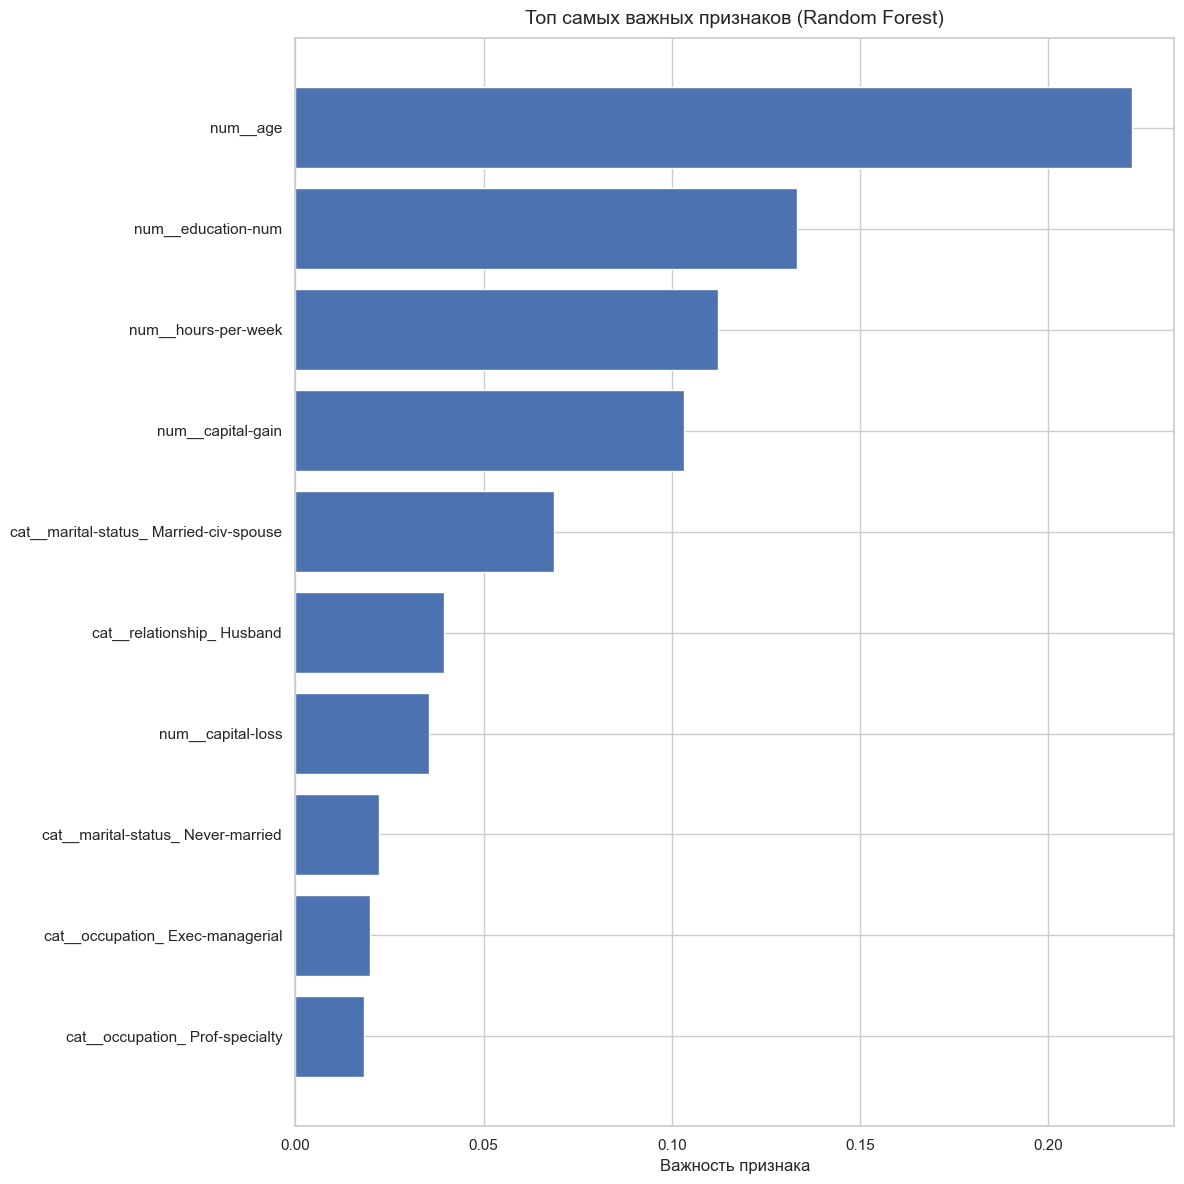

In [132]:
# Визуализация важности признаков (в построении мне помог deepseek)

best_pipeline = grid_search_lr.best_estimator_
feature_selector = best_pipeline.named_steps['feature_selector']
preprocessor = best_pipeline.named_steps['preprocessor']

# имена признаков
all_feature_names = preprocessor.get_feature_names_out()

selected_mask = feature_selector.get_support()
selected_feature_names = all_feature_names[selected_mask]

# важность признаков из RF
rf_model = feature_selector.estimator_
feature_importance = rf_model.feature_importances_

selected_importance = feature_importance[selected_mask]

importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': selected_importance
}).sort_values('importance', ascending=True)

plt.figure(figsize=(12, 12))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Важность признака')
plt.title('Топ самых важных признаков (Random Forest)', fontsize=14, pad=10)
plt.tight_layout()
plt.show()


Как я и предполагал, в топе важных признаков - **возраст, уровень образования**

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [133]:
best_logreg = grid_search_lr1.best_estimator_

coefficients = best_logreg.coef_[0]


feature_names = preprocessor1.get_feature_names_out()

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)
coef_df.head(10)

,feature,coefficient,abs_coefficient
2,num__capital-gain,2.277460,2.277460
16,cat__marital-status_ Married-civ-spouse,1.389327,1.389327
15,cat__marital-status_ Married-AF-spouse,1.277794,1.277794
30,cat__occupation_ Priv-house-serv,-1.232303,1.232303
53,cat__native-country_ Columbia,-1.161285,1.161285
18,cat__marital-status_ Never-married,-1.126334,1.126334
39,cat__relationship_ Own-child,-1.094593,1.094593
89,cat__native-country_ Vietnam,-1.036720,1.036720
41,cat__relationship_ Wife,1.009145,1.009145
47,cat__sex_ Female,-0.980906,0.980906


In [134]:
coef_df.shape

(91, 3)

In [141]:
y_train.shape

(15873,)

In [143]:
X_train_transformed.shape, X_train.shape

((24420, 91), (15873, 12))

In [138]:
# обучаю модель на 40 лучших признаках

top_40_features = coef_df.head(40)['feature'].values


feature_mask = [name in top_40_features for name in feature_names]

X_train_top40 = X_train_transformed[:, feature_mask]
X_test_top40 = X_test_transformed[:, feature_mask]
#y_train_top40 = y_train[feature_mask]


logreg_top40 = LogisticRegression(penalty='l2', random_state=777, max_iter=1000)
grid_search_top40 = GridSearchCV(
    logreg_top40, 
    param_grid, 
    cv=5, 
    verbose=2, 
    scoring='average_precision'
)
grid_search_top40.fit(X_train_top40, y_train)

# оцениваю на тестовой выборке
y_test_pred_top40 = grid_search_top40.predict_proba(X_test_top40)[:, 1]
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_top40)
pr_auc_top40 = auc(recall_vals, precision_vals)

print("Best Hyperparameters:", grid_search_top40.best_params_)
print("Best Cross-Validation Score:", grid_search_top40.best_score_)
print("Test PR-AUC Score:", pr_auc_top40)

ValueError: Found input variables with inconsistent numbers of samples: [24420, 15873]

In [139]:
df_metrics_part3.loc['LogReg with 40 best features (selected by weights)'] = [
      round(grid_search_top40.best_score_, 4),
      round(pr_auc_top40, 4),
      100000
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку

display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [351]:
# здесь чуть поломалось при повторном запуске, но выводы ниже верные

Изменилось ли качество? Как?

**Качество чуть улучшилось при отборе по весам!**\
При этом отбор с помощью RandomForest показал худшие результаты на тесте

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Что получилось?

Я **отмасштабировал в самом начале**

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [144]:
y = df['income']
X = df.drop(columns=['fnlwgt', 'income', 'education'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

In [145]:
new_pipeline = Pipeline([
    ('ohe', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )),
    ('scaler', StandardScaler())
])

new_pipeline.fit(X_train)
X_train_scaled = new_pipeline.transform(X_train)
X_valid_scaled = new_pipeline.transform(X_valid)
X_test_scaled = new_pipeline.transform(X_test)


feature_names = new_pipeline.named_steps['ohe'].get_feature_names_out()
print("Имена признаков после OHE + StandardScaler:")
print(feature_names[:40])  # первые 40 признаков

Имена признаков после OHE + StandardScaler:
['cat__workclass_ ?' 'cat__workclass_ Federal-gov'
 'cat__workclass_ Local-gov' 'cat__workclass_ Never-worked'
 'cat__workclass_ Private' 'cat__workclass_ Self-emp-inc'
 'cat__workclass_ Self-emp-not-inc' 'cat__workclass_ State-gov'
 'cat__workclass_ Without-pay' 'cat__marital-status_ Divorced'
 'cat__marital-status_ Married-AF-spouse'
 'cat__marital-status_ Married-civ-spouse'
 'cat__marital-status_ Married-spouse-absent'
 'cat__marital-status_ Never-married' 'cat__marital-status_ Separated'
 'cat__marital-status_ Widowed' 'cat__occupation_ ?'
 'cat__occupation_ Adm-clerical' 'cat__occupation_ Armed-Forces'
 'cat__occupation_ Craft-repair' 'cat__occupation_ Exec-managerial'
 'cat__occupation_ Farming-fishing' 'cat__occupation_ Handlers-cleaners'
 'cat__occupation_ Machine-op-inspct' 'cat__occupation_ Other-service'
 'cat__occupation_ Priv-house-serv' 'cat__occupation_ Prof-specialty'
 'cat__occupation_ Protective-serv' 'cat__occupation_ Sale

In [146]:
X_train_transformed.shape

(24420, 91)

In [147]:
len(feature_mask[:-1])

90

In [152]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'] # решил добавить еще и подбор метода оптимизации
}

In [153]:
top_40_features1 = feature_names[:40]
feature_mask = [name in top_40_features1 for name in feature_names]

X_train_top40 = X_train_scaled[:, feature_mask]
X_test_top40 = X_test_scaled[:, feature_mask]


logreg_top40_ohe_ss = LogisticRegression(penalty='l2', random_state=777, max_iter=1000)
grid_search_top40_ohe_ss = GridSearchCV(
    logreg_top40_ohe_ss, 
    param_grid, 
    cv=5, 
    verbose=2, 
    scoring='average_precision'
)
grid_search_top40_ohe_ss.fit(X_train_top40, y_train)

# оцениваю на тестовой выборке
y_test_pred_top40 = grid_search_top40_ohe_ss.predict_proba(X_test_top40)[:, 1]
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_top40)
pr_auc_top40 = auc(recall_vals, precision_vals)

print("Best Hyperparameters:", grid_search_top40_ohe_ss.best_params_)
print("Best Cross-Validation Score:", grid_search_top40_ohe_ss.best_score_)
print("Test PR-AUC Score:", pr_auc_top40)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.1s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.1s
[CV] END ...........................C=0.01, solv

Качество очень упало. Это связано с тем, что **не стоит использовать методы обработки числовых признаков для категориальных**

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** чем выше модуль корреляции между признаком и таргетом - **тем сильнее линейная взаимосвязь между ними.** Логично предположить, что чем выше корреляция таргета и признаков, тем сильнее предсказательная способность модели. Я бы брал признаки с наибольшей по модулю корреляцией с таргетом.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [154]:
y = df['income']
X = df.drop(columns=['fnlwgt', 'income', 'education'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777)

In [155]:
# подготовка признаков

categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # категориальные признаки
numeric_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'] # числовые признаки

preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])


preprocessor_new.fit(X_train)
X_train_transformed = preprocessor_new.transform(X_train)
X_test_transformed = preprocessor_new.transform(X_test)

In [156]:
# сопоставляю имена со столбцами X_train_transformed

cat_encoder = preprocessor_new.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(cat_feature_names)

print(f"Всего признаков: {len(all_feature_names)}")

Всего признаков: 91


In [157]:
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

X_train_df['target'] = y_train.values

In [158]:
# считаю корреляции
correlations = X_train_df.corr()['target'].sort_values(ascending=False)

correlations.head(3)

target                                1.000000
marital-status_ Married-civ-spouse    0.445139
relationship_ Husband                 0.402061
Name: target, dtype: float64

In [159]:
# беру модули

correlations_abs = np.abs(correlations)
correlations_abs.sort_values(ascending=False).head(41) # беру 40 лучших

target                                   1.000000
marital-status_ Married-civ-spouse       0.445139
relationship_ Husband                    0.402061
education-num                            0.335333
marital-status_ Never-married            0.321466
age                                      0.242854
hours-per-week                           0.233254
relationship_ Own-child                  0.230246
capital-gain                             0.222606
occupation_ Exec-managerial              0.217310
sex_ Male                                0.215847
sex_ Female                              0.215847
relationship_ Not-in-family              0.187458
occupation_ Prof-specialty               0.184577
occupation_ Other-service                0.156271
capital-loss                             0.151761
relationship_ Unmarried                  0.141916
workclass_ Self-emp-inc                  0.140797
marital-status_ Divorced                 0.123625
relationship_ Wife                       0.121776


In [160]:
top_40_corr  = correlations_abs.sort_values(ascending=False).head(41).index.tolist()
top_40_corr = [el for el in top_40_corr if el != 'target']

In [161]:
# обучаю только на них

X_train_corr = X_train_df.drop(columns='target', axis=1)
X_test_corr = X_test_df.copy()

X_train_corr = X_train_corr[top_40_corr]
X_test_corr = X_test_corr[top_40_corr]





In [162]:
LogReg_top40corr = LogisticRegression(penalty='l2', max_iter=1000)
grid_search_lr0 = GridSearchCV(LogReg_top40corr, param_grid, cv = 5, verbose=2, scoring='average_precision') # 5 фолдов для кросс-валидации
grid_search_lr0.fit(X_train_corr, y_train)


y_test_pred_logreg0 = grid_search_lr0.predict_proba(X_test_corr)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg0)
pr_auc_lr0 = auc(recall_vals, precision_vals)


print("Best Hyperparameters:", grid_search_lr0.best_params_)
print("Best Cross-Validation Score:", grid_search_lr0.best_score_)
print("Test Score:", pr_auc_lr0)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.01, solv

In [163]:
df_metrics_part3.loc['LogReg with 40 best features (selected by correlations with target)'] = [
      round( grid_search_lr0.best_score_, 4),
      round(pr_auc_lr0, 4),
      10
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку

display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.764400,0.770800,1.000000
LogReg with 40 best features (selected by RandomForest),0.751500,0.748900,100.000000
LogReg with 40 best features (selected by correlations with target),0.763800,0.767400,10.000000


**Качество почти такое же, как при отборе по весам**

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [165]:
Xt = X_train_df.copy()
Xt.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target
0,-0.333854,-0.036020,-0.145451,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.700949,1.522172,-0.145451,-0.215496,0.369409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,-0.627530,-0.425567,13.220260,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,-0.480692,1.132624,1.260636,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.620591,-0.036020,-0.145451,-0.215496,-0.034999,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Я решил написать **алгоритм отбора с аомощью t-stat в виде функции**

In [166]:
def selection_tstat(frame, target_col, n_best): 

    ft_tstat_list = []

    frame_cl = frame.drop(columns=[target_col], axis=1)
    for ft in frame_cl.columns.tolist():

        m_plus = frame[frame[target_col]==1][ft].mean()
        m_minus = frame[frame[target_col]==0][ft].mean()
        
        n_plus = frame[frame[target_col]==1].shape[0]
        n_minus = frame[frame[target_col]==0].shape[0]
        
        sigma2_plus = frame[frame[target_col]==1][ft].var()
        sigma2_minus = frame[frame[target_col]==0][ft].var()

        t_stat_j = np.abs((m_plus - m_minus)) / np.sqrt((n_plus*sigma2_plus + n_minus*sigma2_minus) / (n_plus + n_minus)) # t-stat для j-го признака

        ft_tstat_list.append({'feature': ft, 't_stat': t_stat_j})

    ft_tstat_frame = pd.DataFrame(ft_tstat_list)

    ft_tstat_frame = ft_tstat_frame.sort_values(by='t_stat', ascending=False)[:n_best] # вывожу n_best лучших


    return ft_tstat_frame
        


In [167]:
start10 = time.time()

best_features_tstat = selection_tstat(Xt, 'target', 40)

time10 = time.time() - start10

print(f'Отбор признаков с помощью t-stat занял {round(time10, 3)} секунд')

Отбор признаков с помощью t-stat занял 2.97 секунд


In [168]:
# обучаю модель на 40 лучших с точки зрения t-stat признаках

top_40_tstat = best_features_tstat['feature']

X_train_tstat = X_train_df.drop(columns='target', axis=1)
X_test_tstat = X_test_df.copy()

X_train_tstat = X_train_corr[top_40_tstat]
X_test_tstat = X_test_corr[top_40_tstat]

In [169]:
LogReg_top40tstat = LogisticRegression(penalty='l2', max_iter=1000)
grid_search_lr000 = GridSearchCV(LogReg_top40tstat, param_grid, cv = 5, verbose=2, scoring='average_precision') # 5 фолдов для кросс-валидации
grid_search_lr000.fit(X_train_tstat, y_train)


y_test_pred_logreg000 = grid_search_lr000.predict_proba(X_test_tstat)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg000)
pr_auc_lr000 = auc(recall_vals, precision_vals)


print("Best Hyperparameters:", grid_search_lr000.best_params_)
print("Best Cross-Validation Score:", grid_search_lr000.best_score_)
print("Test Score:", pr_auc_lr000)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.01, solv

In [170]:
df_metrics_part3.loc['LogReg with 40 best features (selected by t-stat)'] = [
      round( grid_search_lr000.best_score_, 4),
      round(pr_auc_lr000, 4),
      10
]

display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.764400,0.770800,1.000000
LogReg with 40 best features (selected by RandomForest),0.751500,0.748900,100.000000
LogReg with 40 best features (selected by correlations with target),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by t-stat),0.763800,0.767400,10.000000


**Пока не удается пробить качество выше auc_pr_test = 0.7674**

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

Мне понравился **метод с t-stat**, поэтому буду использовать его

In [171]:
X11 = X_train_df.copy()
X11.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male,native-country_ ?,native-country_ Cambodia,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,target
0,-0.333854,-0.036020,-0.145451,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-0.700949,1.522172,-0.145451,-0.215496,0.369409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,-0.627530,-0.425567,13.220260,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,-0.480692,1.132624,1.260636,-0.215496,-0.034999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,0.620591,-0.036020,-0.145451,-0.215496,-0.034999,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [172]:
X_test_11 = X_test_df.copy()

In [173]:
def selection_tstat_11(frame, target_col): 

    ft_tstat_list = []

    frame_cl = frame.drop(columns=[target_col], axis=1)
    for ft in frame_cl.columns.tolist():

        m_plus = frame[frame[target_col]==1][ft].mean()
        m_minus = frame[frame[target_col]==0][ft].mean()
        
        n_plus = frame[frame[target_col]==1].shape[0]
        n_minus = frame[frame[target_col]==0].shape[0]
        
        sigma2_plus = frame[frame[target_col]==1][ft].var()
        sigma2_minus = frame[frame[target_col]==0][ft].var()

        t_stat_j = np.abs((m_plus - m_minus)) / np.sqrt((n_plus*sigma2_plus + n_minus*sigma2_minus) / (n_plus + n_minus)) # t-stat для j-го признака

        ft_tstat_list.append({'feature': ft, 't_stat': t_stat_j})

    ft_tstat_frame = pd.DataFrame(ft_tstat_list)

    ft_tstat_frame = ft_tstat_frame.sort_values(by='t_stat', ascending=False)                # возвращаю таблицу признаков по убыванию важности согласно t-stat


    return ft_tstat_frame
        

In [174]:
def wrapper(frame_train):
    k = frame_train.shape[1] - 1

    pbar = tqdm(total=k-40)  # для отслеживания прогресса

    frame_train_upd = frame_train.drop('target', axis=1)

    current_features = frame_train_upd.columns.tolist()

    while k > 40:

        ft_tstat_frame_11 = selection_tstat_11(frame_train[current_features + ['target']], 'target')

        features_step_i = ft_tstat_frame_11['feature'].tolist()[:-1]      # на каждом шаге выкидываю по 1 самому худшему признаку

        current_features = features_step_i

        k -= 1
        pbar.update(1) 

    pbar.close()    

    return features_step_i 

In [175]:
start11 = time.time()


features_selected_by_wrapper = wrapper(X11)

time11 = time.time() - start11
print(f'Отбор признаков с помощью метода обертки занял {round(time11, 3)} секунд')

100%|██████████| 51/51 [01:12<00:00,  1.43s/it]

Отбор признаков с помощью метода обертки занял 72.711 секунд


In [176]:
features_selected_by_wrapper[:2]

['marital-status_ Married-civ-spouse', 'relationship_ Husband']

In [177]:
# обучаю модель на отобранных признаках и смотрю качество

X11 = X11.drop(columns='target', axis=1)

X_train_11 = X11[features_selected_by_wrapper]
X_test_11 = X_test_11[features_selected_by_wrapper]



LogReg_top40wrapper = LogisticRegression(penalty='l2', max_iter=1000)
grid_search_lr111 = GridSearchCV(LogReg_top40wrapper, param_grid, cv = 5, verbose=2, scoring='average_precision') # 5 фолдов для кросс-валидации
grid_search_lr111.fit(X_train_11, y_train)


y_test_pred_logreg111 = grid_search_lr111.predict_proba(X_test_11)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg111)
pr_auc_lr111 = auc(recall_vals, precision_vals)


print("Best Hyperparameters:", grid_search_lr111.best_params_)
print("Best Cross-Validation Score:", grid_search_lr111.best_score_)
print("Test Score:", pr_auc_lr111)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.01, solv

In [178]:
df_metrics_part3.loc['LogReg with 40 best features (selected by wrapper)'] = [
      round( grid_search_lr111.best_score_, 4),
      round(pr_auc_lr111, 4),
      10
]

display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.764400,0.770800,1.000000
LogReg with 40 best features (selected by RandomForest),0.751500,0.748900,100.000000
LogReg with 40 best features (selected by correlations with target),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by t-stat),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by wrapper),0.763800,0.767400,10.000000


In [179]:
len(set(top_40_tstat) & set(features_selected_by_wrapper))

40

Получается, отбор с помощью t-stat и отбор с помощью t-stat несколькими итерациями дают **одинаковый набор признаков**

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [180]:
X12 = X_train_df.copy()
X_test_12 = X_test_df.copy()

In [181]:
# реализовываю алгоритм с добавлением признаков

def wrapper_reversed(frame_train):
    k = 1

    pbar = tqdm(total=k-40)  # для отслеживания прогресса

    frame_train_upd = frame_train.drop('target', axis=1)

    current_features = frame_train_upd.columns.tolist()

    ft_tstat_frame_11 = selection_tstat_11(frame_train[current_features + ['target']], 'target')

    while k <= 40:

        

        features_step_j = ft_tstat_frame_11['feature'].tolist()[:k]      # на каждом шаге добавляю по 1 признаку

        current_features = features_step_j

        k += 1
        pbar.update(1) 

    pbar.close()    

    return features_step_j

In [182]:
start12 = time.time()


features_selected_by_reversed_wrapper = wrapper_reversed(X12)

time12 = time.time() - start12
print(f'Отбор признаков с помощью обратного метода обертки занял {round(time12, 3)} секунд')

40it [00:02, 14.16it/s]

Отбор признаков с помощью обратного метода обертки занял 2.83 секунд


**Намного быстрее!**

In [183]:
# обучаю модель на отобранных признаках и смотрю качество

X12 = X12.drop(columns='target', axis=1)

X_train_12 = X12[features_selected_by_reversed_wrapper]
X_test_12 = X_test_12[features_selected_by_reversed_wrapper]



LogReg_top40wrapper_rev = LogisticRegression(penalty='l2', max_iter=1000)
grid_search_lr1112 = GridSearchCV(LogReg_top40wrapper_rev, param_grid, cv = 5, verbose=2, scoring='average_precision') # 5 фолдов для кросс-валидации
grid_search_lr1112.fit(X_train_12, y_train)


y_test_pred_logreg1112 = grid_search_lr1112.predict_proba(X_test_12)[:,1]

precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred_logreg1112)
pr_auc_lr1112 = auc(recall_vals, precision_vals)


print("Best Hyperparameters:", grid_search_lr1112.best_params_)
print("Best Cross-Validation Score:", grid_search_lr1112.best_score_)
print("Test Score:", pr_auc_lr1112)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..........................C=0.001, solver=liblinear; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=0.001, solver=lbfgs; total time=   0.0s
[CV] END ...........................C=0.01, solver=liblinear; total time=   0.0s
[CV] END ...........................C=0.01, solv

In [184]:
df_metrics_part3.loc['LogReg with 40 best features (selected by reversed wrapper)'] = [
      round( grid_search_lr1112.best_score_, 4),
      round(pr_auc_lr1112, 4),
      10
]

display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.764400,0.770800,1.000000
LogReg with 40 best features (selected by RandomForest),0.751500,0.748900,100.000000
LogReg with 40 best features (selected by correlations with target),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by t-stat),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by wrapper),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by reversed wrapper),0.763800,0.767400,10.000000


Ожидаемо, **качество такое же**

Построим **визуализацию динамики качества на тестовой выборке** с добавлением новых признаков

In [185]:
X13 = X_train_df.copy()
X_test_13 = X_test_df.copy()

Я строю модель без подбора гиперпараметров GridSearch, так как иначе **вычисления слишком долгие**

In [186]:
k = 1
arr_k = [k]

ft_tstat_frame_11 = selection_tstat_11(X13, 'target')
sorted_features = ft_tstat_frame_11['feature'].tolist()

aucs = [0]
X_test_13_full = X_test_13[sorted_features]

total_iterations = X13.shape[1] - 1 - k
pbar = tqdm(total=total_iterations)

simple_logreg = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)

while k < X13.shape[1] - 1:
    current_features = sorted_features[:k]
    
    X_train_13 = X13[current_features]
    X_test_13 = X_test_13_full[current_features]
    
    simple_logreg.fit(X_train_13, y_train)
    y_test_pred = simple_logreg.predict_proba(X_test_13)[:,1]
    
    precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_test_pred)
    pr_auc_lr1112 = auc(recall_vals, precision_vals)
    
    k += 1
    arr_k.append(k)
    aucs.append(pr_auc_lr1112)
    pbar.update(1)

pbar.close()
print('Готово')

100%|██████████| 90/90 [00:15<00:00,  5.98it/s]

Готово


In [187]:
len(arr_k), len(aucs)

(91, 91)

Строю график:

In [188]:
import plotly.express as px

fig = px.line(x=arr_k, 
              y=aucs,
              title='Динамика качества при добавлении признаков',
              color_discrete_sequence=["#7E1279"])

fig.update_layout(
    xaxis_title='Количество признаков',          
    yaxis_title='PR-AUC',
    title_font_size=20,     
    font=dict(size=12)     
)

In [354]:
# график можно посмотреть в Quality_dynamics.png

Явного **ухудшения качества, начиная с какого-то порога, не наблюдается**.\
Просто, начиная с ~30 признаков **качество выходит на ассимптоту**

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?


In [189]:
display(df_metrics_part3.style
    .background_gradient(subset=['auc_pr_test'], cmap='RdYlGn'))

,auc_pr_valid,auc_pr_test,reg_const
LogReg,0.764400,0.770800,1.000000
LogReg with 40 best features (selected by RandomForest),0.751500,0.748900,100.000000
LogReg with 40 best features (selected by correlations with target),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by t-stat),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by wrapper),0.763800,0.767400,10.000000
LogReg with 40 best features (selected by reversed wrapper),0.763800,0.767400,10.000000


Что касается качества, все методы, кроме отбора с помощью Random Forest, дали **практически идентичный результат** => есть ядро из 40 сильных признаков.\
Самым долгим с отрывом оказался отбор с помощью метода-обертки.\
Главный минус методов обертки - **вычислительная сложность и скорость выполнения**.\
Метод с отбором с помощью tstat хорош, но **требует нормальности распределения.**\
Метод с корреяциями также дал высокий результат, но он **не учитывает взаимодействия признаков.**\
Метод с весами модели тоже дал высокий результат, но в каких-то других случаях он может **упускать нелинейные закономерности**

Самое интересное, что **наилучшее качество у ЛогРега без отбора признаков**

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [190]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional-full.csv', sep=';')

Взял описание из интернета

**Демографические признаки:**
- `age` - возраст клиента в годах
- `job` - тип профессии/рода занятий
- `marital` - семейное положение
- `education` - уровень образования
- `default` - наличие кредита в дефолте
- `housing` - наличие жилищного кредита
- `loan` - наличие персонального кредита

**Связанные с текущим контактом:**
- `contact` - тип средства связи
- `month` - последний месяц контакта в году
- `day_of_week` - последний день недели контакта
- `duration` - продолжительность последнего контакта в секундах

**Прочие атрибуты:**
- `campaign` - количество контактов во время этой кампании
- `pdays` - количество дней с последнего контакта
- `previous` - количество контактов до этой кампании
- `poutcome` - результат предыдущей маркетинговой кампании

**Экономические показатели:**
- `emp.var.rate` - коэффициент вариации занятости
- `cons.price.idx` - индекс потребительских цен
- `cons.conf.idx` - индекс потребительского доверия
- `euribor3m` - ставка Euribor за 3 месяца
- `nr.employed` - количество сотрудников

**Целевая переменная:**
- `y` - подписал ли клиент срочный депозит (бинарный)

In [191]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [192]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [193]:
# я добавил несколько возможных целевых метрик в этот шаблон

In [194]:
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score

def cross_validate(
    X,
    y,
    model,
    n_splits=5,
    random_state=None,
    shuffle=False,
    scoring=None # целевая метрика
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if scoring is None:
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Обучаем модель
        model.fit(X_train, y_train)


        # для average_precision нужны вероятности
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            # Если модель не имеет predict_proba, используем decision_function
            y_pred_proba = model.decision_function(X_test)
        
        # Предсказываем
        y_pred = model.predict(X_test)
        

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        if 'accuracy' in scoring:
            metric_dict['accuracy'] = accuracy_score(y_test, y_pred)
        if 'precision' in scoring:
            metric_dict['precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        if 'recall' in scoring:
            metric_dict['recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        if 'f1' in scoring:
            metric_dict['f1'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        if 'average_precision' in scoring:
            metric_dict['average_precision'] = average_precision_score(y_test, y_pred_proba)    
        
        metrics.append(metric_dict)
    
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

На лекции рассказывали, что для подобных задач хорошо подходит **lift** и похожие на него метрики.\
Поэтому я решил использовать **precision_at_k** - доля True Positives среди первых К элементов проранжированного по убыванию вероятности принадлежности к положительному классу ряда объектов.\
Также есть **Average Precision** - метрика, отражающая средний precision на позициях, где есть TP элементы.

In [195]:
X.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


In [196]:
target_value = 'admin.'

for col in X.columns:
    if X[col].dtype == 'object':  # проверяем только текстовые столбцы
        if target_value in X[col].values:
            print(f"Значение '{target_value}' найдено в столбце: {col}")
            print(f"Все уникальные значения в '{col}': {X[col].unique()}")

Значение 'admin.' найдено в столбце: job
Все уникальные значения в 'job': ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']


In [197]:
X = X.replace('admin.', 'administrator')

In [198]:
df['nr.employed'].unique()

array([5191. , 5228.1, 5195.8, 5176.3, 5099.1, 5076.2, 5017.5, 5023.5,
       5008.7, 4991.6, 4963.6])

In [199]:
# подготовка признаков

categorical_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']  # категориальные признаки
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'] # числовые признаки

preprocessor12 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])


preprocessor12.fit(X)
X_transformed = preprocessor12.transform(X)

In [200]:
model = LogisticRegression(random_state=777)

In [201]:
X_transformed_df = pd.DataFrame(X_transformed)

In [202]:
results_ap = cross_validate(
    X_transformed_df, y, model,
    n_splits=5,
    scoring=['average_precision']  # только интересующая нас метрика - average_precision
)

print("Average Precision по фолдам:")
print(results_ap)
print(f"\nСредний Average Precision: {results_ap['average_precision'].mean():.4f}")

Average Precision по фолдам:
   average_precision
0           0.032575
1           0.060129
2           0.066929
3           0.280905
4           0.525838

Средний Average Precision: 0.1933


Качество ужасное. Посмотрим на баланс классов:

In [203]:
y.value_counts()

y
False    36548
True      4640
Name: count, dtype: int64

Наблюдается **сильный дисбаланс классов**. Скорее всего, качество низкое из-за него. Попробую обучить лог регрессию с балансировкой классов:

In [204]:
balanced_lr = LogisticRegression(
    random_state=777,
    class_weight='balanced',  # автоматическая балансировка
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)

In [205]:
results_ap = cross_validate(
    X_transformed_df, y, balanced_lr,
    n_splits=5,
    scoring=['average_precision']  # только интересующая нас метрика - average_precision
)

print("Average Precision по фолдам:")
print(results_ap)
print(f"\nСредний Average Precision: {results_ap['average_precision'].mean():.4f}")

Average Precision по фолдам:
   average_precision
0           0.033252
1           0.060893
2           0.069850
3           0.271180
4           0.482276

Средний Average Precision: 0.1835


**Балансировка не помогла**.\
Попробуем прикинуть силу признаков, оценив корреляции

In [207]:
# Анализ корреляции признаков с целевой переменной

y_numeric = y
correlations = []
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        corr = np.corrcoef(X[col], y_numeric)[0, 1]
        correlations.append((col, corr, abs(corr)))

correlations.sort(key=lambda x: x[2], reverse=True)

print("Топ-10 признаков по корреляции:")
for col, corr, abs_corr in correlations[:10]:
    print(f"{col:20} | Корреляция: {corr:7.3f}")

Топ-10 признаков по корреляции:
nr.employed          | Корреляция:  -0.355
pdays                | Корреляция:  -0.325
euribor3m            | Корреляция:  -0.308
emp.var.rate         | Корреляция:  -0.298
previous             | Корреляция:   0.230
cons.price.idx       | Корреляция:  -0.136
campaign             | Корреляция:  -0.066
cons.conf.idx        | Корреляция:   0.055
age                  | Корреляция:   0.030


Признаки **очень слабо коррелированы с таргетом** => такое плохое качество ожидаемо

Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [211]:
# Функция для расчета прибыли
def calculate_profit(y_true, y_pred_proba, threshold=0.5):

    y_pred = (y_pred_proba >= threshold).astype(int)
    
    n_calls = np.sum(y_pred)
    
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    
    call_cost = -2 * n_calls  
    revenue = 10 * true_positives  
    profit = revenue + call_cost
    
    return profit

In [223]:
def calculate_costs(y_true, y_pred_proba, threshold=0.5):

    y_pred = (y_pred_proba >= threshold).astype(int)
    
    n_calls = np.sum(y_pred)
    
    true_positives = np.sum((y_pred == 1) & (y_true == 1))
    
    call_cost = -2 * n_calls  
    revenue = 10 * true_positives  
    profit = revenue + call_cost
    
    return call_cost

Для подсчета прибыли я изменил cross-validate

In [212]:
from sklearn.base import clone

In [225]:
def simple_cross_validate(estimator, X, y, cv=5):
    from sklearn.model_selection import KFold
    from sklearn.metrics import average_precision_score
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    ap_scores = []
    profits = []
    costs = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        ap_score = average_precision_score(y_test, y_pred_proba)
        ap_scores.append(ap_score)
        
        profit = calculate_profit(y_test.values, y_pred_proba, threshold=0.5)
        profits.append(profit)

        cost = calculate_costs(y_test.values, y_pred_proba, threshold=0.5)
        costs.append(cost)
    
    return ap_scores, profits, costs

ap_scores, profits, costs = simple_cross_validate(balanced_lr, X_transformed_df, y, cv=5)


In [233]:
scores_profits_costs = pd.DataFrame()
scores_profits_costs['scores'] = ap_scores
scores_profits_costs['profits'] = profits
scores_profits_costs['costs'] = costs

In [235]:
print(f'В среднем мы заработаем {scores_profits_costs['profits'].mean()}$')

print(f'Стандартное отклонение прибыли = {round(scores_profits_costs['profits'].std(), 4)}$')

print(f'Отдать операторам придется  в среднем {np.abs(scores_profits_costs['costs'].mean())}$')

В среднем мы заработаем 2522.0$
Стандартное отклонение прибыли = 305.2868$
Отдать операторам придется  в среднем 3316.0$


In [238]:
results_ap['profit'] = scores_profits_costs['profits']
results_ap['proportion'] = results_ap['profit'] / results_ap['average_precision']
results_ap

,average_precision,profit,proportion
0,0.033252,2884,86731.176448
1,0.060893,2158,35439.440791
2,0.069850,2620,37508.984196
3,0.271180,2256,8319.184414
4,0.482276,2692,5581.866265


**Нельзя сказать, что метрики пропорциональны**

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [240]:
# Функция для расчета прибыли
def calculate_profit_random(y_true, y_pred_proba, threshold=0.5):

    y_pred = (y_pred_proba >= threshold).astype(int)
    
    n_calls = np.sum(y_pred)
    
    true_positives = np.sum((y_pred == 1) & (y_true == 1))


    if true_positives > 0:
        random_revenues = np.random.uniform(0, 20, true_positives)
        total_revenue = np.sum(random_revenues)
    else:
        total_revenue = 0
    
    call_cost = -2 * n_calls   
    profit = total_revenue + call_cost
    
    return profit

In [241]:
def simple_cross_validate_random_profit(estimator, X, y, cv=5):
    from sklearn.model_selection import KFold
    from sklearn.metrics import average_precision_score
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    ap_scores = []
    profits = []
    costs = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        ap_score = average_precision_score(y_test, y_pred_proba)
        ap_scores.append(ap_score)
        
        profit = calculate_profit_random(y_test.values, y_pred_proba, threshold=0.5)
        profits.append(profit)

        cost = calculate_costs(y_test.values, y_pred_proba, threshold=0.5)
        costs.append(cost)
    
    return ap_scores, profits, costs

ap_scores, profits, costs = simple_cross_validate_random_profit(balanced_lr, X_transformed_df, y, cv=5)

In [242]:
scores_profits_costs = pd.DataFrame()
scores_profits_costs['scores'] = ap_scores
scores_profits_costs['profits'] = profits
scores_profits_costs['costs'] = costs

scores_profits_costs

,scores,profits,costs
0,0.471672,2898.014996,-3246
1,0.430023,2156.375906,-3312
2,0.437752,2618.845883,-3420
3,0.420238,2373.812380,-3234
4,0.487813,2809.267861,-3368


In [244]:
results_ap['profit2'] = scores_profits_costs['profits']
results_ap['proportion2'] = results_ap['profit2'] / results_ap['average_precision']
results_ap

,average_precision,profit,proportion,profit2,proportion2
0,0.033252,2884,86731.176448,2898.014996,87152.652556
1,0.060893,2158,35439.440791,2156.375906,35412.769343
2,0.069850,2620,37508.984196,2618.845883,37492.461385
3,0.271180,2256,8319.184414,2373.812380,8753.627197
4,0.482276,2692,5581.866265,2809.267861,5825.021359


In [263]:
print(f'Средняя прибыль при равномерно распределенном выигрыше = {round(results_ap['profit2'].mean(), 3)}')

Средняя прибыль при равномерно распределенном выигрыше = 2571.263


**Результаты схожи**, средняя прибыли при случайном выигрыше чуть выше

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
def simple_cross_val_profit(estimator, X, y, C_values, cv=5):

    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    results = {}
    
    for C in tqdm(C_values):
        profits_fold = []
        
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Создаем модель с конкретным C
            model = clone(estimator)
            model.set_params(C=C)  
            
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            profit = calculate_profit_random(y_test.values, y_pred_proba, threshold=0.5)
            profits_fold.append(profit)
        
        results[C] = {
            'mean_profit': np.mean(profits_fold),
            'all_profits': profits_fold
        }
    
    return results



In [248]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
results = simple_cross_val_profit(balanced_lr, X_transformed_df, y, C_values, cv=5)



100%|██████████| 8/8 [00:17<00:00,  2.14s/it]


In [250]:
results = pd.DataFrame(results)
results

,0.001,0.010,0.100,1.000,10.000,100.000,1000.000,10000.000
mean_profit,1997.532269,2295.039887,2503.239221,2564.120026,2544.212415,2590.256382,2622.989771,2507.999428
all_profits,"[2418.4484477572123, 1721.2094705830004, 2096....","[2570.035391459249, 2132.8481137025083, 2252.3...","[2885.632215453701, 2145.5809485429872, 2660.6...","[2947.1950745726244, 2228.4052834137456, 2850....","[2763.9744976315806, 2119.36508950409, 2716.17...","[2892.8337277090122, 2185.914331837319, 2804.0...","[3112.410791044582, 2298.202258235059, 2693.50...","[2887.7759081830854, 2291.948904725853, 2499.7..."


In [255]:
maxprofit = results.max(axis=1)['mean_profit']
c_maxprofit = results.idxmax(axis=1)['mean_profit']
print(f'Прибыль максимальна при коэффициенте регуляризации = {c_maxprofit}  и равна {round(results.max(axis=1)['mean_profit'], 3)} $')

Прибыль максимальна при коэффициенте регуляризации = 1000.0  и равна 2622.99 $


**Прибыль выше на ~50$**, выигрыш есть, но он не очень большой

### График зависимости ожидаемой прибыли от коэффициента регуляризации

In [269]:
import plotly.express as px

In [272]:
c_reg = np.array(results.columns)
mean_profits = np.array(results.iloc[0].values)



fig = px.line(x=c_reg, 
              y=mean_profits, 
              title='Зависимость ожидаемой прибыли от коэффициента регуляризации',
              color_discrete_sequence=["#098117"])

fig.update_layout(
    xaxis_title='Коэффициент регуляризации',          
    yaxis_title='Ожидаемая прибыль',
    title_font_size=20,     
    font=dict(size=12)     
)

fig.update_traces(
    line_width=2       
)

fig.show()

In [355]:
# график можно посмотреть в Profit_dynamics_by_reg_coef.png

Для наглядности построю такой же график без учета больших C

In [276]:
c_reg = np.array(results.columns)
mean_profits = np.array(results.iloc[0].values)



fig = px.line(x=c_reg[:-3], 
              y=mean_profits[:-3], 
              title='Зависимость ожидаемой прибыли от коэффициента регуляризации',
              color_discrete_sequence=["#098117"])

fig.update_layout(
    xaxis_title='Коэффициент регуляризации',          
    yaxis_title='Ожидаемая прибыль',
    title_font_size=20,     
    font=dict(size=12)     
)

fig.update_traces(
    line_width=2       
)

fig.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [ ]:
def simple_cross_val_profit_several_times(estimator, X, y, C_values, cv=5):

    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    results = {}
    
    for C in tqdm(C_values):
        profits_fold = []
        
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Создаем модель с конкретным C
            model = clone(estimator)
            model.set_params(C=C)  
            
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            profit = calculate_profit_random(y_test.values, y_pred_proba, threshold=0.5)
            profits_fold.append(profit)
        
        results[C] = {
            'mean_profit': np.mean(profits_fold),
            'all_profits': profits_fold
        }
        results = pd.DataFrame(results)
    
    return results.idxmax(axis=1)['mean_profit']

In [281]:
# запускаю функцию 10 раз

[simple_cross_val_profit_several_times(balanced_lr, X_transformed_df, y, C_values, cv=5) for _ in range(10)]

100%|██████████| 8/8 [00:23<00:00,  2.89s/it]


[1000.0, 10000.0, 100.0, 1.0, 1.0, 100.0, 1000.0, 100.0, 100.0, 10000.0]

**Вывод**: в большинстве случаев C большой => **сильная регуляризация не нужна**\
Я думаю можно использовать C=10000 или 1000, скорее всего разница будет небольшая

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ recall здесь важнее, так как **высокий recall => меньше пропускаем готовых заключить депозит клиентов**\
Издержки на звонок меньше ожидаемой прибыли от заключения депозита, поэтому precision не так важен



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [328]:
def simple_cross_val_profit_threshold(estimator, X, y, thresholds, C, cv=5):

    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    results = {}
    
    for threshold in tqdm(thresholds):
        profits_fold = []
        recalls_fold = [] 
        
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            # Создаем модель с конкретным C
            model = clone(estimator)
            model.set_params(C=C)  
            
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            
            profit = calculate_profit_random(y_test.values, y_pred_proba, threshold=threshold)
            profits_fold.append(profit)

            y_pred = (y_pred_proba >= threshold).astype(int)
            recalls_fold.append(recall_score(y_test, y_pred))
        
        results[threshold] = {
            'mean_profit': np.mean(profits_fold),
            'profis_by_folds': profits_fold,
            'mean_recalls': np.mean(recalls_fold) 
        }
        results = pd.DataFrame(results)
    
    return results


In [329]:
thresholds = np.arange(0, 1.01, 0.01)
results = simple_cross_val_profit_threshold(balanced_lr, X_transformed_df, y, thresholds, C = 10000, cv=5)

 99%|█████████▉| 100/101 [04:29<00:01,  1.46s/it]C:\Users\User\AppData\Local\Temp\ipykernel_1920\2368663644.py:29: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

100%|██████████| 101/101 [04:30<00:00,  2.68s/it]


In [330]:
results

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,...,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.60,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.00
mean_profit,-7281.142799,-7110.401362,-7202.295524,-7221.962647,-7118.711388,-7041.151195,-7200.887672,-7256.699626,-7131.500695,-7239.296941,-7269.155364,-7101.427443,-7106.806705,-7155.701676,-7152.619447,-7075.568884,-6870.417909,-6839.432951,-6835.232699,-6442.668561,-5865.981634,-5532.88598,-4927.936134,-4571.620837,-3987.431237,-3483.243863,-3118.655172,-2771.096733,-2355.385844,-2039.512531,-1617.500264,-1185.777586,-706.033671,-313.867309,203.770511,474.35348,843.217358,1127.719353,1346.132967,1497.26641,1635.574514,1809.014131,1948.722729,2060.69058,2051.481947,2167.765601,2224.898151,2374.195086,2361.123346,2473.875236,...,2556.552444,2546.83695,2644.380316,2660.793972,2822.134335,2546.437673,2750.399646,2696.150187,2815.723557,2902.366149,2835.99928,2750.670153,2851.364184,2820.21203,2879.444262,2783.425356,2751.80115,2646.072434,2669.225284,2598.133117,2447.740611,2630.068503,2622.218997,2600.044694,2477.360579,2454.702916,2449.066576,2391.1058,2416.347056,2264.961751,2214.711279,2026.58275,1966.686061,1893.175943,1863.171769,1759.548396,1597.822558,1532.637508,1519.357371,1355.961411,1348.263888,1277.588289,1149.867918,926.915759,790.725253,496.332012,324.296565,94.450385,0.0,0.0
profis_by_folds,"[-6554.210397152781, -7412.353181138291, -7514...","[-6284.382522958827, -6838.278249782552, -7466...","[-6594.868382397228, -7166.335238988946, -7710...","[-6731.544284799787, -7360.099563639429, -7034...","[-6362.424698753368, -7277.05917448629, -7266....","[-6374.927187503956, -7128.090942737184, -7398...","[-6450.027522270353, -7024.07157402622, -7485....","[-6653.165355083729, -7453.519304886147, -7446...","[-6365.751914039238, -7233.185820542374, -7343...","[-6637.773767250674, -7389.097697255478, -7259...","[-6907.186008114864, -7285.977588215001, -7121...","[-6190.540053206983, -7239.787422855257, -7292...","[-6475.026073252859, -7152.515822422392, -7143...","[-6752.808788447874, -7091.425164469101, -7508...","[-6514.271740926335, -7242.699371800714, -7248...","[-6381.847184552551, -6989.542297892822, -7145...","[-6020.521518261328, -7211.091353955711, -7123...","[-6265.89039977195, -7163.627067215537, -6953....","[-6239.517117879865, -6677.024075484882, -7011...","[-5798.003127430609, -6415.271463934994, -6481...","[-5454.65571700428, -5832.084659549153, -5897....","[-5134.501299509975, -5003.4474675123165, -565...","[-4171.388719774379, -4529.518993880618, -5097...","[-4031.870939439157, -4583.121768788373, -4676...","[-3606.5279029249086, -4229.931710674944, -390...","[-3224.8770043494515, -3296.0038375401127, -33...","[-2596.699067839967, -3240.9249507690665, -330...","[-1892.7855695001417, -2373.209760310514, -320...","[-1869.6776671967746, -2550.824463393462, -250...","[-1703.6561754800605, -2080.16771881185, -2148...","[-982.9429402356982, -1778.8787227421371, -189...","[-647.2154062862346, -1028.6216779026845, -154...","[-112.15513709821971, -866.2774523146709, -100...","[240.61801853295947, -416.3624499363714, -618....","[983.5121106681163, -19.639168531737596, -204....","[1013.5061234921495, 384.03561429791625, 454.4...","[1292.7195685159722, 737.9275796375332, 565.99...","[1699.6132627443048, 954.0321871539509, 1066.2...","[1909.6559991997283, 1343.73521258453, 1056.07...","[1782.87682956336, 1242.7253810531574, 1468.65...","[2463.439293248266, 1335.0800010072835, 1492.4...","[2443.099020980818, 1529.4382740402643, 1793.8...","[2437.2460958964093, 1595.978444686083, 1985.5...","[2577.2184554656496, 1775.4032

In [331]:
maxprofit = results.max(axis=1)['mean_profit']
t_maxprofit = results.idxmax(axis=1)['mean_profit']
recall_maxprofit = results[t_maxprofit]['mean_recalls']
print(f'Прибыль максимальна при пороге бинаризации = {t_maxprofit}  и равна {round(maxprofit, 3)} $. Recall в таком случае = {round(recall_maxprofit, 3)}')

Прибыль максимальна при пороге бинаризации = 0.6  и равна 2902.366 $. Recall в таком случае = 0.601


**Recall достаточно низкий при максимальной прибыли**. Построим графики зависимости Recall и прибыли от порога бинаризации

In [335]:
trs = np.array(results.columns)
profits = results.iloc[0].values
recalls = results.iloc[2].values

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог

In [333]:
fig = px.line(x=trs, 
              y=profits, 
              title='Зависимость ожидаемой прибыли от порога бинаризации',
              color_discrete_sequence=["#7E1279"])

fig.update_layout(
    xaxis_title='Порог бинаризации',          
    yaxis_title='Ожидаемая прибыль',
    title_font_size=20,     
    font=dict(size=12)     
)

fig.add_scatter(
    x=[results.idxmax(axis=1)['mean_profit']], 
    y=[results.max(axis=1)['mean_profit']],
    mode='markers',
    marker=dict(
        color='red',
        size=12,
        symbol='star',  # Звезда вместо круга
        line=dict(color='darkred', width=2)
    ),
    name=f'Максимум: {results.max(axis=1)['mean_profit']:.2f} \
           Порог = {results.idxmax(axis=1)['mean_profit']}'
)

fig.update_layout(
    xaxis_title='Порог бинаризации',          
    yaxis_title='Ожидаемая прибыль',
    title_font_size=20,     
    font=dict(size=12)     
)

fig.update_traces(
    line_width=2       
)

fig.show()

In [356]:
# график можно посмотреть в Profit_dynamics_by_binarization_threshold.png

In [336]:
fig = px.line(x=trs, 
              y=recalls, 
              title='Зависимость Recall от порога бинаризации',
              color_discrete_sequence=["#5F1268"])

fig.update_layout(
    xaxis_title='Порог бинаризации',          
    yaxis_title='Recall',
    title_font_size=20,     
    font=dict(size=12)     
)

fig.update_traces(
    line_width=2       
)

fig.show()

In [357]:
# график можно посмотреть в Recall_dynamics_by_binarization_threshold.png

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Да, **оптимальный порог всегда в районе 0.6 - 0.7**\
Это говорит о том, что с точки зрения максимизации прибыли, **лучше пропустить несколько клиентов, чем звонить всем подряд**\
Порог 0.6 - 0.7 дает оптимальный **баланс между precision и recall**\
При низком пороге Recall высокий, но слишком много ложных срабатываний => **огромные издержки**

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [339]:
# обучаю дефолтный логрег

def simple_cross_val_profit_default_df(estimator, X, y, cv=5):
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=777)
    
    profits_fold = []
    recalls_fold = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = clone(estimator)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        profit = calculate_profit_random(y_test.values, y_pred_proba, threshold=0.5)
        profits_fold.append(profit)

        y_pred = (y_pred_proba >= 0.5).astype(int)
        recalls_fold.append(recall_score(y_test, y_pred))
    
    results_def = pd.DataFrame({
        'mean_profit': [np.mean(profits_fold)],
        'profits_by_folds': [profits_fold],
        'mean_recall': [np.mean(recalls_fold)],
    })
    
    return results_def

results_default = simple_cross_val_profit_default_df(balanced_lr, X_transformed_df, y, cv=5)
results_default

,mean_profit,profits_by_folds,mean_recall
0,2445.894341,"[2833.7715628525257, 2212.4165759097395, 2368....",0.629258


In [342]:
# Оптимизированная лог регрессия
results[t_maxprofit]

mean_profit                                              2902.366149
profis_by_folds    [3030.89594964338, 2508.237296264302, 3159.113...
mean_recalls                                                0.601214
Name: 0.6, dtype: object

In [347]:
print(f'Ожидаемая прибыль для оптимизированной модели = {np.array(results[t_maxprofit]['profis_by_folds']).mean():.2f}, стандартное отклонение прибыли = {np.array(results[t_maxprofit]['profis_by_folds']).std():.2f}')

print(f'Ожидаемая прибыль для дефолтной модели = {np.array(results_default.iloc[0]['profits_by_folds']).mean():.2f}, стандартное отклонение прибыли = {np.array(results_default.iloc[0]['profits_by_folds']).std():.2f}')

Ожидаемая прибыль для оптимизированной модели = 2902.37, стандартное отклонение прибыли = 258.71
Ожидаемая прибыль для дефолтной модели = 2445.89, стандартное отклонение прибыли = 249.09


**Средние сильно различаются, посмотрим, статистически значима ли эта разница**

У нас парные наблюдения и маленькая выборка => подходит **ttest_rel**

In [349]:
from scipy.stats import ttest_rel

profit_model_default = np.array(results_default.iloc[0]['profits_by_folds'])
profit_model_ortimized = np.array(results[t_maxprofit]['profis_by_folds'])

t_stat, p_value = ttest_rel(profit_model_ortimized, profit_model_default, alternative='greater') # проверяю гипотезу что ожидаемая прибыль оптимальной модели выше чем дефолтной

print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.3f}")

t-статистика: 4.471
p-value: 0.006


In [350]:
p_value < 0.05

True

p-value < уровня значимости => нулевая гипотеза отвергается => **Оптимизированная модель значимо лучше**